In [2]:
import string
import re
import numpy as np
from collections import Counter, defaultdict
import textstat
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from transformers import BertTokenizerFast, pipeline
import torch
import accelerate
from typing import List, Dict, Union
import pandas as pd
import numpy as np
import nltk
import re # Make sure re is imported
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat # Assuming textstat is available

c:\Users\User\.local\share\mamba\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
traits = ['Openness','Conscientiousness','Extraversion','Agreeableness','Emotional stability','Humility']

# separate functions

class TextFeatureExtractor:
    """
    A class to extract various linguistic and sentiment features from text data,
    designed to work with a Pandas DataFrame where each row contains a list of
    comment strings for a user/entry.
    """

    def __init__(self,
                 specific_punctuation_to_track: list = None,
                 readability_agg_method: str = "concat",
                 ttr_agg_method: str = "concat"):
        """
        Initializes the TextFeatureExtractor.

        Args:
            specific_punctuation_to_track (list, optional):
                A list of specific punctuation marks to count.
                Defaults to ['!', '?', '.', ','].
            readability_agg_method (str, optional):
                Method to aggregate readability scores ("concat" or "mean").
                Defaults to "concat".
            ttr_agg_method (str, optional):
                Method to aggregate Type-Token Ratio ("concat" or "mean").
                Defaults to "concat".
        """
        self.vader_analyzer = SentimentIntensityAnalyzer()

        if specific_punctuation_to_track is None:
            self.specific_punctuation_to_track = ['!', '?', '.', ',',':',';']
        else:
            self.specific_punctuation_to_track = specific_punctuation_to_track

        self.readability_agg_method = readability_agg_method
        self.ttr_agg_method = ttr_agg_method

        try:
            nltk.data.find('tokenizers/punkt')
        except nltk.downloader.DownloadError:
            print("NLTK 'punkt' tokenizer not found. Downloading...", flush=True)
            nltk.download('punkt', quiet=True)
        except LookupError: # Sometimes it's a LookupError if path is configured but resource missing
             print("NLTK 'punkt' tokenizer not found (LookupError). Downloading...", flush=True)
             nltk.download('punkt', quiet=True)


    # --- I. Basic structural feature helpers (operating on lists from a single DataFrame row) ---

    def _sentence_split(self, comment_list: list) -> list:
        """Splits each comment in a list of comments into sentences."""
        all_sentences_for_user = []
        if not isinstance(comment_list, list): return []
        for comment_text in comment_list:
            if isinstance(comment_text, str) and comment_text.strip():
                sentences = nltk.sent_tokenize(comment_text)
                all_sentences_for_user.append(sentences)
            else:
                all_sentences_for_user.append([]) # Handle empty or non-string comments
        return all_sentences_for_user # Returns list of lists of sentences e.g. [[s1,s2],[s3,s4,s5]]

    def _get_word_counts_per_comment(self, comment_list: list) -> list:
        """Calculates word count for each comment string in a list."""
        if not isinstance(comment_list, list): return []
        return [len(str(comment).split()) if isinstance(comment, str) else 0 for comment in comment_list]

    def _get_sentence_counts_per_comment(self, list_of_sentence_lists: list) -> list:
        """Counts sentences in each original comment (given pre-split sentences)."""
        if not isinstance(list_of_sentence_lists, list): return []
        return [len(sentences_in_one_comment) if isinstance(sentences_in_one_comment, list) else 0 for sentences_in_one_comment in list_of_sentence_lists]

    def _get_sentence_word_counts_per_comment(self, list_of_sentence_lists: list) -> list:
        """Calculates word counts for each sentence within each original comment."""
        result_for_user = []
        if not isinstance(list_of_sentence_lists, list): return []
        for sentences_in_one_comment in list_of_sentence_lists:
            if isinstance(sentences_in_one_comment, list):
                sent_lens = [len(str(sent).split()) if isinstance(sent, str) else 0 for sent in sentences_in_one_comment]
                result_for_user.append(sent_lens)
            else:
                result_for_user.append([])
        return result_for_user

    def _aggregate_numeric_list_of_lists(self, list_of_lists_of_numbers: list, agg_func) -> float:
        """Flattens a list of lists of numbers and applies an aggregation function."""
        if not isinstance(list_of_lists_of_numbers, list): return np.nan
        flat_list = []
        for sublist in list_of_lists_of_numbers:
            if isinstance(sublist, list):
                flat_list.extend(num for num in sublist if isinstance(num, (int, float)) and not np.isnan(num))
        return agg_func(flat_list) if flat_list else np.nan

    def _aggregate_numeric_list(self, list_of_numbers: list, agg_func) -> float:
        """Applies an aggregation function to a list of numbers."""
        if not isinstance(list_of_numbers, list): return np.nan
        valid_numbers = [num for num in list_of_numbers if isinstance(num, (int, float)) and not np.isnan(num)]
        return agg_func(valid_numbers) if valid_numbers else np.nan

    # --- II. Single-text processing helper methods (private) ---

    def _get_punctuation_counts_single(self, text: str) -> dict:
        if not isinstance(text, str): return {}
        counts = Counter(char for char in text if char in self.specific_punctuation_to_track)
        return {punc: counts.get(punc, 0) for punc in self.specific_punctuation_to_track}

    def _get_double_whitespace_count_single(self, text: str) -> int:
        """Counts occurrences of two or more consecutive whitespace characters."""
        if not isinstance(text, str) or not text.strip():
            return 0
        # Find all non-overlapping matches of 2 or more whitespace characters
        matches = re.findall(r"\s{2,}", text)
        return len(matches)

    def _get_readability_scores_single(self, text: str) -> dict:
        if not isinstance(text, str) or not text.strip():
            return {'flesch_reading_ease': np.nan, 'gunning_fog': np.nan}
        try:
            return {
                'flesch_reading_ease': textstat.flesch_reading_ease(text),
                'gunning_fog': textstat.gunning_fog(text)
            }
        except Exception:
            return {'flesch_reading_ease': np.nan, 'gunning_fog': np.nan}

    def _get_mean_word_length_single(self, text: str) -> float:
        if not isinstance(text, str) or not text.strip(): return np.nan
        words = re.findall(r'\b\w+\b', text.lower())
        if not words: return np.nan
        return sum(len(word) for word in words) / len(words)

    def _get_type_token_ratio_single(self, text: str) -> float:
        if not isinstance(text, str) or not text.strip(): return np.nan
        words = re.findall(r'\b\w+\b', text.lower())
        if not words: return np.nan
        return len(set(words)) / len(words) if len(words) > 0 else np.nan

    def _get_vader_sentiment_scores_single(self, text: str) -> dict:
        if not isinstance(text, str):
            return {'sentiment_neg': np.nan, 'sentiment_neu': np.nan,
                    'sentiment_pos': np.nan, 'sentiment_compound': np.nan}
        scores = self.vader_analyzer.polarity_scores(text)
        return {
            'sentiment_neg': scores['neg'], 'sentiment_neu': scores['neu'],
            'sentiment_pos': scores['pos'], 'sentiment_compound': scores['compound']
        }

    # --- III. Methods for processing a LIST of comments from one user/row ---

    def _get_aggregated_punctuation_counts_from_list(self, comment_list: list) -> dict:
        if not isinstance(comment_list, list) or not comment_list:
            return {punc: 0 for punc in self.specific_punctuation_to_track}

        total_counts = Counter()
        for comment_text in comment_list:
            if isinstance(comment_text, str):
                single_comment_punc_counts = self._get_punctuation_counts_single(comment_text)
                total_counts.update(single_comment_punc_counts)
        return dict(total_counts)

    def _get_aggregated_double_whitespace_from_list(self, comment_list: list) -> int:
        """Aggregates double whitespace counts from a list of comments."""
        if not isinstance(comment_list, list) or not comment_list:
            return 0
        
        total_double_whitespace = 0
        for comment_text in comment_list:
            if isinstance(comment_text, str):
                total_double_whitespace += self._get_double_whitespace_count_single(comment_text)
        return total_double_whitespace

    def _get_readability_scores_from_list(self, comment_list: list) -> dict:
        default_scores = {'flesch_reading_ease_agg': np.nan, 'gunning_fog_agg': np.nan}
        if not isinstance(comment_list, list) or not comment_list: return default_scores

        valid_comments = [c for c in comment_list if isinstance(c, str) and c.strip()]
        if not valid_comments: return default_scores

        if self.readability_agg_method == "concat":
            full_text = " ".join(valid_comments)
            scores = self._get_readability_scores_single(full_text)
            return {f"{k}_agg": v for k, v in scores.items()}
        elif self.readability_agg_method == "mean":
            flesch_s, gunning_s = [], []
            for ct in valid_comments:
                s = self._get_readability_scores_single(ct)
                if not np.isnan(s['flesch_reading_ease']): flesch_s.append(s['flesch_reading_ease'])
                if not np.isnan(s['gunning_fog']): gunning_s.append(s['gunning_fog'])
            return {
                'flesch_reading_ease_agg': np.nanmean(flesch_s) if flesch_s else np.nan,
                'gunning_fog_agg': np.nanmean(gunning_s) if gunning_s else np.nan
            }
        raise ValueError("Invalid readability_agg_method.")

    def _get_mean_word_length_from_list(self, comment_list: list) -> float:
        if not isinstance(comment_list, list) or not comment_list: return np.nan
        lengths = [self._get_mean_word_length_single(c) for c in comment_list if isinstance(c, str)]
        valid_lengths = [l for l in lengths if not np.isnan(l)]
        return np.nanmean(valid_lengths) if valid_lengths else np.nan

    def _get_ttr_from_list(self, comment_list: list) -> float:
        if not isinstance(comment_list, list) or not comment_list: return np.nan
        valid_comments = [c for c in comment_list if isinstance(c, str) and c.strip()]
        if not valid_comments: return np.nan

        if self.ttr_agg_method == "concat":
            return self._get_type_token_ratio_single(" ".join(valid_comments))
        elif self.ttr_agg_method == "mean":
            ttrs = [self._get_type_token_ratio_single(c) for c in valid_comments]
            valid_ttrs = [ttr for ttr in ttrs if not np.isnan(ttr)]
            return np.nanmean(valid_ttrs) if valid_ttrs else np.nan
        raise ValueError("Invalid ttr_agg_method.")

    def _get_aggregated_sentiment_from_list(self, comment_list: list) -> dict:
        default_scores = {'mean_sentiment_neg': np.nan, 'mean_sentiment_neu': np.nan,
                          'mean_sentiment_pos': np.nan, 'mean_sentiment_compound': np.nan,
                          'std_sentiment_compound': np.nan}
        if not isinstance(comment_list, list) or not comment_list: return default_scores

        scores_acc = {'neg': [], 'neu': [], 'pos': [], 'compound': []}
        for comment_text in comment_list:
            if isinstance(comment_text, str):
                single_s = self._get_vader_sentiment_scores_single(comment_text)
                for key_base in scores_acc.keys():
                    val = single_s[f'sentiment_{key_base}']
                    if not np.isnan(val): scores_acc[key_base].append(val)

        results = {}
        for key_base, val_list in scores_acc.items():
            results[f'mean_sentiment_{key_base}'] = np.nanmean(val_list) if val_list else np.nan

        comp_list = scores_acc['compound']
        results['std_sentiment_compound'] = np.nanstd(comp_list) if comp_list and len(comp_list) > 1 else 0.0 if comp_list else np.nan
        return results

    # --- IV. Main Public Method ---
    def extract_features(self, df: pd.DataFrame, comment_column: str = 'comments', output_prefix: str = "") -> pd.DataFrame:
        """
        Extracts all defined text features and adds them to the DataFrame.

        Args:
            df (pd.DataFrame): The input DataFrame.
            comment_column (str): The name of the column in df that contains
                                  lists of comment strings for each row/user.
            output_prefix (str, optional): A prefix to add to all new feature
                                           column names. Defaults to "".

        Returns:
            pd.DataFrame: The DataFrame with added feature columns.
        """
        if comment_column not in df.columns:
            raise ValueError(f"Column '{comment_column}' not found in DataFrame.")

        if not df[comment_column].apply(lambda x: isinstance(x, (list, tuple, np.ndarray))).all():
            print(f"Warning: Not all entries in '{comment_column}' are lists/tuples/np.ndarray. Ensure data format is correct.", flush=True)


        # --- 1. Basic structural features ---
        df[f'{output_prefix}comment_word_counts'] = df[comment_column].apply(self._get_word_counts_per_comment)
        df[f'{output_prefix}mean_words_per_comment'] = df[f'{output_prefix}comment_word_counts'].apply(lambda x: self._aggregate_numeric_list(x, np.mean))
        df[f'{output_prefix}median_words_per_comment'] = df[f'{output_prefix}comment_word_counts'].apply(lambda x: self._aggregate_numeric_list(x, np.median))
        df[f'{output_prefix}total_words'] = df[f'{output_prefix}comment_word_counts'].apply(lambda x: self._aggregate_numeric_list(x, np.sum))

        df_sent_col = df[comment_column].apply(self._sentence_split)
        df_sent_counts_per_comment_col = df_sent_col.apply(self._get_sentence_counts_per_comment)
        df[f'{output_prefix}mean_sents_per_comment'] = df_sent_counts_per_comment_col.apply(lambda x: self._aggregate_numeric_list(x, np.mean))
        df[f'{output_prefix}median_sents_per_comment'] = df_sent_counts_per_comment_col.apply(lambda x: self._aggregate_numeric_list(x, np.median))
        df[f'{output_prefix}total_sents'] = df_sent_counts_per_comment_col.apply(lambda x: self._aggregate_numeric_list(x, np.sum))

        df_sent_word_counts_col = df_sent_col.apply(self._get_sentence_word_counts_per_comment)
        df[f'{output_prefix}mean_words_per_sentence'] = df_sent_word_counts_col.apply(lambda x: self._aggregate_numeric_list_of_lists(x, np.mean))
        df[f'{output_prefix}median_words_per_sentence'] = df_sent_word_counts_col.apply(lambda x: self._aggregate_numeric_list_of_lists(x, np.median))

        df[f'{output_prefix}sents_per_comment_skew'] = df[f'{output_prefix}mean_sents_per_comment'] - df[f'{output_prefix}median_sents_per_comment']
        df[f'{output_prefix}words_per_sentence_skew'] = df[f'{output_prefix}mean_words_per_sentence'] - df[f'{output_prefix}median_words_per_sentence']

        # --- 1b. Double Whitespace Count ---  NEW SECTION
        df[f'{output_prefix}total_double_whitespace'] = df[comment_column].apply(self._get_aggregated_double_whitespace_from_list)


        # --- 2. Punctuation Features ---
        punc_data_col = df[comment_column].apply(self._get_aggregated_punctuation_counts_from_list)
        # Note: Your hardcoded col_name_punc has 'd_ws'. If you want 'total_double_whitespace' to be
        # named 'punc_d_ws_total' and be part of this loop, you'd need a different approach.
        # For now, 'd_ws' in col_name_punc will likely result in a column of zeros if it's not
        # in self.specific_punctuation_to_track with a corresponding character.
        col_name_punc = ['em','qm','period','comma','colon','semicolon'] # Adjusted: removed 'd_ws' as it's handled separately
        actual_punc_to_track = self.specific_punctuation_to_track[:len(col_name_punc)] # Ensure lists align

        for punc_char, punc_name in zip(actual_punc_to_track, col_name_punc):
            df[f'{output_prefix}punc_{punc_name}_total'] = punc_data_col.apply(lambda d: d.get(punc_char, 0))


        # --- 3. Readability Features ---
        readability_df = df[comment_column].apply(self._get_readability_scores_from_list).apply(pd.Series)
        readability_df.columns = [f'{output_prefix}{col}' for col in readability_df.columns]
        df = pd.concat([df, readability_df], axis=1)

        # --- 4. Mean Word Length (lexical diversity proxy) ---
        df[f'{output_prefix}mean_word_len_overall'] = df[comment_column].apply(self._get_mean_word_length_from_list)

        # --- 5. Type-Token Ratio (lexical richness) ---
        df[f'{output_prefix}ttr_overall'] = df[comment_column].apply(self._get_ttr_from_list)

        # --- 6. Sentiment Features ---
        sentiment_df = df[comment_column].apply(self._get_aggregated_sentiment_from_list).apply(pd.Series)
        sentiment_df.columns = [f'{output_prefix}{col}' for col in sentiment_df.columns]
        df = pd.concat([df, sentiment_df], axis=1)

        return df
    
def show_corr(df,cols_drop=None,size=(15,7),save=False,save_name='UNKNOWN'):
    df_num = df.select_dtypes(include=['float64','int64'])
    if cols_drop != None:
        df_num.drop(cols_drop,axis=1,inplace=True)
    corr = df_num.corr()
    plt.figure(figsize=size)
    sns.heatmap(corr,annot=True,cmap='seismic',fmt='.2f',vmin=-1,vmax=1)
    if save:
        plt.savefig(f'{save_name}.png',dpi=300)
    plt.show()

    return

import re
import pandas as pd

def clean_train(df):
    # Option 1: Your original pattern (for comments that are *entirely* URLs)
    # url_pattern_entire_string = re.compile(r"^(?:(?:https?:\/\/)?(?:www\.)?)?([a-zA-Z0-9-]+(?:\.[a-zA-Z0-9-]+)+)(?::[0-9]{1,5})?(?:\/[^\s]*)?(?:\?[^\s#]*)?(?:#[^\s]*)?$")

    # Option 2: A more general pattern to find URLs embedded within text
    # This one is simpler and commonly used for http(s) links.
    url_pattern_embedded = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    # You might want another for "www.domain.com" type links if not covered
    www_pattern_embedded = re.compile(r'(?:^|[^a-zA-Z0-9])(www\.[a-zA-Z0-9][a-zA-Z0-9.-]+[a-zA-Z0-9]\.[a-zA-Z]{2,6}(?:/[^\s]*)?)')


    # We will build a new list for the 'comments' column
    new_comments_column = []

    for idx, row in df.iterrows():
        current_comment_list = row.get('comments') # Use .get() for safety

        if not isinstance(current_comment_list, list):
            # If the entry for 'comments' is not a list (e.g., None, NaN, float, str),
            # append it as is. This is crucial for the warning you saw.
            new_comments_column.append(current_comment_list)
            print('non list still found')
            continue # Move to the next row

        cleaned_list_for_this_row = []
        for single_comment_string in current_comment_list:
            if isinstance(single_comment_string, str):
                # Apply cleaning using the embedded pattern (Option 2)
                temp_comment = re.sub(url_pattern_embedded, '', single_comment_string)
                temp_comment = re.sub(www_pattern_embedded, '', temp_comment)

                # If you intended Option 1 (entire string is URL):
                # if re.fullmatch(url_pattern_entire_string, single_comment_string):
                #    temp_comment = '[URL COMMENT REMOVED]'
                # else:
                #    temp_comment = single_comment_string
                cleaned_list_for_this_row.append(temp_comment)
            else:
                # If an item within the list is not a string (e.g. None), keep it.
                cleaned_list_for_this_row.append(single_comment_string)
        
        new_comments_column.append(cleaned_list_for_this_row)

    # Assign the newly built list of lists back to the DataFrame column
    df['comments'] = new_comments_column
    return df

# Example of how to use it:
# Assuming df_train is your DataFrame
# df_train = clean_train_corrected(df_train.copy()) # Use .copy() if you want to avoid modifying the original df_train in place


def get_q_score(input):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    classifier = pipeline(
        'zero-shot-classification',
        model='facebook/bart-large-mnli',
        device = device
    )

    labels = [
        'an answer to: "Please describe a situation where you were presented with a problem outside of your comfort zone and where you were able to come up with a creative solution."', #q1
        'an answer to: "Tell us about a time when you have failed or made a mistake. What happened? What did you learn from this experience?"', #q2
        'an answer to: "Describe a situation in which you got a group of people to work together as a team. Did you encounter any issues? What was the end result?"' #q3
    ]



    for i, user in enumerate(input):
        print(f'{i+1}/{len(input)}')
        user_comments = user.get('comments')
        if user_comments and isinstance(user_comments, list) and len(user_comments) > 0:
            try:
                results = classifier(user_comments, labels, multi_label=True)

                user_results = []
                for result in results:
                    try:
                        result = {label: round(score,4) for label, score in zip(result['labels'], result['scores'])}
                        result_dict = {
                            'Q1_score': result['an answer to: "Please describe a situation where you were presented with a problem outside of your comfort zone and where you were able to come up with a creative solution."'],
                            'Q2_score': result['an answer to: "Tell us about a time when you have failed or made a mistake. What happened? What did you learn from this experience?"'],
                            'Q3_score': result['an answer to: "Describe a situation in which you got a group of people to work together as a team. Did you encounter any issues? What was the end result?"']
                        }
                        
                        user_results.append([v for v in result_dict.values()])
                    except Exception as e:
                        print(f'{e}')
                user['features']['q_scores'] = user_results
            except Exception as e:
                print(f'{e}')
        else: print('OOPY')
    
    return input

def append_q_score_train(input, q_score_path):
    with open(q_score_path,'r',encoding='utf-8') as f:
        data = json.load(f)
    
    for input_user, data_user in zip(input,data):
        
        q_scores = []
        for comment_q_scores in data_user['comment_classifications']:
            temp_q = [v for v in comment_q_scores.values()]
            q_scores.append(temp_q)
        input_user['features']['q_scores'] = q_scores
    return input


def to_input(df):
    input = []
    for index, row in df.iterrows():
        input_user = {}
        comments = row['comments']

        if traits[0] in df.columns:             # train and val
            # labels
            labels = {}
            for trait in traits:
                labels[trait] = row[trait]
            input_user = {
                'comments': comments,
                'labels': labels
            }
        else:                                   # test
            input_user = {
                'comments': comments
            }
        # num features
        input_user['features'] = {} 
        df_num = df.select_dtypes(include=['float64','int64'])
        for col in df_num.columns:
            if col in traits or col == 'id':
                continue
            else: input_user['features'][col] = round(row[col],4)
        input.append(input_user)
    return input



def pretokenize(
    comments: List[str],
    model_name: str = "bert-base-uncased",
    max_length: int = 512,
    padding_strategy: Union[str, bool] = "max_length", # or True/'longest'
    truncation_strategy: bool = True,
    return_tensors_type: str = 'pt' # 'pt' for PyTorch, 'tf' for TensorFlow, None for Python lists
) -> Dict[str, List[List[int]]]:
    """
    Tokenizes a list of comments separately using a BERT tokenizer.

    Args:
        comments (List[str]): A list of strings, where each string is a comment.
        model_name (str): The pretrained BERT model name (e.g., "bert-base-uncased").
        max_length (int): The maximum sequence length. Comments longer than this
                          will be truncated. BERT's typical max is 512.
        padding_strategy (Union[str, bool]):
            - True or 'longest': Pad to the longest sequence in the batch.
            - 'max_length': Pad to `max_length`.
            - 'do_not_pad' or False: Do not pad.
            Recommended: 'max_length' or True if you plan to batch.
        truncation_strategy (bool): Whether to truncate sequences longer than `max_length`.
                                    Should generally be True for BERT.
        return_tensors_type (str, optional): If set, will return tensors of a
            specific framework ('pt' for PyTorch, 'tf' for TensorFlow).
            If None, returns lists of integers. Defaults to None.

    Returns:
        transformers.tokenization_utils_base.BatchEncoding:
        A dictionary-like object containing:
            - 'input_ids': List of lists of token IDs.
            - 'token_type_ids': List of lists of token type IDs (segment IDs).
            - 'attention_mask': List of lists of attention masks.
        Each inner list corresponds to one of the input comments.
    """
    if not comments:
        print("Warning: Input comments list is empty.")
        return {
            "input_ids": [],
            "token_type_ids": [],
            "attention_mask": [],
        }

    try:
        # Load the tokenizer
        # Using BertTokenizerFast for speed, it provides the same API as BertTokenizer
        tokenizer = BertTokenizerFast.from_pretrained(model_name)
    except OSError:
        print(f"Error: Could not load tokenizer for model '{model_name}'. "
              "Ensure the model name is correct and you have an internet connection "
              "if downloading for the first time.")
        # Return an empty structure or raise an error as appropriate
        return {
            "input_ids": [[] for _ in comments],
            "token_type_ids": [[] for _ in comments],
            "attention_mask": [[] for _ in comments],
        }


    # Tokenize the list of comments
    # The tokenizer can handle a list of texts directly.
    # It will tokenize each text and apply padding/truncation as specified.
    # `add_special_tokens=True` is the default and adds [CLS] and [SEP]
    tokenized_output = tokenizer(
        comments,
        add_special_tokens=True,        # Adds [CLS] and [SEP]
        max_length=max_length,
        padding=padding_strategy,
        truncation=truncation_strategy,
        return_attention_mask=True,     # Explicitly ask for attention mask
        return_token_type_ids=True,   # Explicitly ask for token type ids
        return_tensors=return_tensors_type
    )

    return tokenized_output

import json
import torch # Assuming BatchEncoding contains PyTorch tensors
from transformers.tokenization_utils_base import BatchEncoding # For type checking and instantiation

# --- Constants for marking types in JSON ---
_TENSOR_MARKER = "__tensor__"
_TENSOR_DTYPE_MARKER = "__tensor_dtype__"
_BATCH_ENCODING_MARKER = "__batch_encoding__"
_BATCH_ENCODING_DATA_MARKER = "data"

def _convert_dtype_to_str(dtype):
    """Converts a torch.dtype to a string representation."""
    # This mapping might need to be expanded for other dtypes
    # Alternatively, just use str(dtype) e.g. "torch.int64"
    # and torch.__getattribute__(str_dtype.split('.')[1]) for loading
    return str(dtype)

def _convert_str_to_dtype(dtype_str):
    """Converts a string representation back to a torch.dtype."""
    if not dtype_str.startswith("torch."):
        # Fallback for simple dtype names if str(dtype) was used without "torch." prefix
        # Or if it's a very basic type like 'float32' that torch.dtype can parse
        try:
            return torch.__getattribute__(dtype_str)
        except AttributeError:
            return torch.dtype(dtype_str) # Try direct parsing

    # For strings like "torch.int64"
    dtype_name = dtype_str.split('.')[1]
    return torch.__getattribute__(dtype_name)


def _recursive_encode(obj):
    """
    Recursively traverses the object and converts tensors and BatchEncoding
    to JSON-serializable representations.
    """
    if isinstance(obj, torch.Tensor):
        return {
            _TENSOR_MARKER: True,
            _BATCH_ENCODING_DATA_MARKER: obj.tolist(),
            _TENSOR_DTYPE_MARKER: _convert_dtype_to_str(obj.dtype)
        }
    elif isinstance(obj, BatchEncoding):
        # BatchEncoding is dict-like. We need to encode its items.
        # We also mark that this dictionary was originally a BatchEncoding.
        return {
            _BATCH_ENCODING_MARKER: True,
            _BATCH_ENCODING_DATA_MARKER: {k: _recursive_encode(v) for k, v in obj.items()}
        }
    elif isinstance(obj, dict):
        return {k: _recursive_encode(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [_recursive_encode(item) for item in obj]
    # Add other custom types here if needed
    return obj # For primitive types

def encode_for_json(data_to_encode):
    """
    Encodes data containing PyTorch tensors and BatchEncoding objects
    into a JSON-serializable format.
    """
    return _recursive_encode(data_to_encode)

def _json_object_hook(dct):
    """
    Object hook for json.load or json.loads to reconstruct
    tensors and BatchEncoding objects.
    """
    if _TENSOR_MARKER in dct:
        dtype_str = dct.get(_TENSOR_DTYPE_MARKER, 'float32') # Default to float32 if not found
        dtype = _convert_str_to_dtype(dtype_str)
        return torch.tensor(dct[_BATCH_ENCODING_DATA_MARKER], dtype=dtype)
    elif _BATCH_ENCODING_MARKER in dct:
        # The items within dct['data'] should have already been processed
        # by this hook if they were tensors or other BatchEncodings.
        return BatchEncoding(dct[_BATCH_ENCODING_DATA_MARKER])
    return dct # Return dict as is if not a special type

def decode_from_json(json_data):
    """
    Decodes JSON data (string or file pointer) back into Python objects,
    reconstructing PyTorch tensors and BatchEncoding objects.
    
    :param json_data: JSON string or a file-like object (e.g., opened file).
    """
    if isinstance(json_data, str):
        return json.loads(json_data, object_hook=_json_object_hook)
    else: # Assuming file-like object
        return json.load(json_data, object_hook=_json_object_hook)

# COMBINED FUNCTION
def df_preprocess(df_path):
    extractor = TextFeatureExtractor()

    
    if isinstance(df_path,str):
        df = pd.read_csv(df_path)

        if traits[0] in df.columns: #VAL
            print('processing val')
            df['comments'] = df[['Q1','Q2','Q3']].astype(str).values.tolist()
            for trait in traits:
                df[trait] = df[trait]/100
            print('extracting features')
            df_feat = extractor.extract_features(df.copy())
            df_feat.to_csv('df_val_feat.csv')
            show_corr(df_feat,save=True,cols_drop='id',save_name='val_corr')
            print('turning into dict')
            input_dict = to_input(df_feat)
            print('getting q_scores')
            temp_input_structure_for_users = get_q_score(input_dict)
            print('Tokenizing and writing user by user to JSONL file...')
            output_file_path = 'val_data.jsonl'
            with open(output_file_path, 'w', encoding='utf-8') as outfile:
                for i, user_data_item in enumerate(temp_input_structure_for_users):
                    print(f"Processing user {i+1}/{len(temp_input_structure_for_users)}")

                    # Tokenize comments for this user (apply chunking here if a user has many comments)
                    user_comments_list = user_data_item.get('comments', [])
                    string_comments = [str(c) for c in user_comments_list if isinstance(c, (str, int, float))] # Ensure strings
                    
                    # Implement your chunked pretokenize logic here for string_comments
                    # For simplicity, let's assume pretokenize handles a potentially large list
                    # by chunking or that a single user's tokenization is manageable
                    if string_comments:
                        # --- Incorporate the chunking logic for pretokenize for this user ---
                        MAX_COMMENTS_PER_TOKENIZE_CHUNK = 1024 
                        all_tokenized_chunks_for_user = {"input_ids": [], "token_type_ids": [], "attention_mask": []}
                        for chunk_start_idx in range(0, len(string_comments), MAX_COMMENTS_PER_TOKENIZE_CHUNK):
                            comment_chunk = string_comments[chunk_start_idx : chunk_start_idx + MAX_COMMENTS_PER_TOKENIZE_CHUNK]
                            tokenized_output_chunk = pretokenize(comment_chunk, return_tensors_type='pt')
                            all_tokenized_chunks_for_user["input_ids"].append(tokenized_output_chunk["input_ids"])
                            all_tokenized_chunks_for_user["token_type_ids"].append(tokenized_output_chunk["token_type_ids"])
                            all_tokenized_chunks_for_user["attention_mask"].append(tokenized_output_chunk["attention_mask"])
                        
                        # Concatenate chunks for this user
                        final_input_ids = torch.cat(all_tokenized_chunks_for_user["input_ids"], dim=0) if all_tokenized_chunks_for_user["input_ids"] else torch.empty(0,0, dtype=torch.long)
                        # ... similar for token_type_ids, attention_mask
                        final_token_type_ids = torch.cat(all_tokenized_chunks_for_user["token_type_ids"], dim=0) if all_tokenized_chunks_for_user["token_type_ids"] else torch.empty(0,0, dtype=torch.long)
                        final_attention_mask = torch.cat(all_tokenized_chunks_for_user["attention_mask"], dim=0) if all_tokenized_chunks_for_user["attention_mask"] else torch.empty(0,0, dtype=torch.long)

                        tokenized_data_for_this_user = BatchEncoding({
                            "input_ids": final_input_ids,
                            "token_type_ids": final_token_type_ids,
                            "attention_mask": final_attention_mask
                        })
                        user_data_item['features']['comments_tokenized'] = tokenized_data_for_this_user
                    else:
                        user_data_item['features']['comments_tokenized'] = pretokenize([]) # empty tokenization

                    # Encode just this user's data for JSON
                    del user_data_item['comments']
                    encoded_user_data = encode_for_json(user_data_item)
                    
                    # Write this user's JSON object, followed by a newline
                    json.dump(encoded_user_data, outfile)
                    outfile.write('\n')
                    
                    # Optionally, clear parts of user_data_item if it helps release memory sooner,
                    # though Python's GC should handle it as `user_data_item` gets redefined in the next iteration.
                    # del user_data_item['features']['comments_tokenized'] # Tensors are now in encoded_user_data as lists

            print(f"Finished processing. Data streamed to {output_file_path}")
            return None # Or path to the file, as data_dict is not returned

        



        else: #TEST
            print('processing test')
            df['comments'] = df[['Q1','Q2','Q3']].astype(str).values.tolist()
            print('extracting features')
            df_feat = extractor.extract_features(df.copy())
            print('turning into dict')
            input_dict = to_input(df_feat)
            print('getting q_scores')
            temp_input_structure_for_users = get_q_score(input_dict)
            print('Tokenizing and writing user by user to JSONL file...')
            output_file_path = 'test_data.jsonl'
            with open(output_file_path, 'w', encoding='utf-8') as outfile:
                for i, user_data_item in enumerate(temp_input_structure_for_users):
                    print(f"Processing user {i+1}/{len(temp_input_structure_for_users)}")

                    # Tokenize comments for this user (apply chunking here if a user has many comments)
                    user_comments_list = user_data_item.get('comments', [])
                    string_comments = [str(c) for c in user_comments_list if isinstance(c, (str, int, float))] # Ensure strings
                    
                    # Implement your chunked pretokenize logic here for string_comments
                    # For simplicity, let's assume pretokenize handles a potentially large list
                    # by chunking or that a single user's tokenization is manageable
                    if string_comments:
                        # --- Incorporate the chunking logic for pretokenize for this user ---
                        MAX_COMMENTS_PER_TOKENIZE_CHUNK = 1024 
                        all_tokenized_chunks_for_user = {"input_ids": [], "token_type_ids": [], "attention_mask": []}
                        for chunk_start_idx in range(0, len(string_comments), MAX_COMMENTS_PER_TOKENIZE_CHUNK):
                            comment_chunk = string_comments[chunk_start_idx : chunk_start_idx + MAX_COMMENTS_PER_TOKENIZE_CHUNK]
                            tokenized_output_chunk = pretokenize(comment_chunk, return_tensors_type='pt')
                            all_tokenized_chunks_for_user["input_ids"].append(tokenized_output_chunk["input_ids"])
                            all_tokenized_chunks_for_user["token_type_ids"].append(tokenized_output_chunk["token_type_ids"])
                            all_tokenized_chunks_for_user["attention_mask"].append(tokenized_output_chunk["attention_mask"])
                        
                        # Concatenate chunks for this user
                        final_input_ids = torch.cat(all_tokenized_chunks_for_user["input_ids"], dim=0) if all_tokenized_chunks_for_user["input_ids"] else torch.empty(0,0, dtype=torch.long)
                        # ... similar for token_type_ids, attention_mask
                        final_token_type_ids = torch.cat(all_tokenized_chunks_for_user["token_type_ids"], dim=0) if all_tokenized_chunks_for_user["token_type_ids"] else torch.empty(0,0, dtype=torch.long)
                        final_attention_mask = torch.cat(all_tokenized_chunks_for_user["attention_mask"], dim=0) if all_tokenized_chunks_for_user["attention_mask"] else torch.empty(0,0, dtype=torch.long)

                        tokenized_data_for_this_user = BatchEncoding({
                            "input_ids": final_input_ids,
                            "token_type_ids": final_token_type_ids,
                            "attention_mask": final_attention_mask
                        })
                        user_data_item['features']['comments_tokenized'] = tokenized_data_for_this_user
                    else:
                        user_data_item['features']['comments_tokenized'] = pretokenize([]) # empty tokenization

                    # Encode just this user's data for JSON
                    del user_data_item['comments']
                    encoded_user_data = encode_for_json(user_data_item)
                    
                    # Write this user's JSON object, followed by a newline
                    json.dump(encoded_user_data, outfile)
                    outfile.write('\n')
                    
                    # Optionally, clear parts of user_data_item if it helps release memory sooner,
                    # though Python's GC should handle it as `user_data_item` gets redefined in the next iteration.
                    # del user_data_item['features']['comments_tokenized'] # Tensors are now in encoded_user_data as lists

            print(f"Finished processing. Data streamed to {output_file_path}")
            return None # Or path to the file, as data_dict is not returned






    else: #TRAIN
        print('processing train')
        #print('cleaning')
        #df_clean = clean_train(df_path)
        print('extracting features')
        df_feat = extractor.extract_features(df_path.copy())
        df_feat.to_csv('df_train_feat.csv')
        #show_corr(df_feat, save=True,save_name='train_corr')
        print('turning intoo dict')
        temp_input_structure_for_users = to_input(df_feat) 

        print('appending q_scores')
        # append_q_score_train modifies temp_input_structure_for_users in place
        temp_input_structure_for_users = append_q_score_train(temp_input_structure_for_users, r'q_scored.json') 

        print('Tokenizing and writing user by user to JSONL file...')
        output_file_path = 'train_data.jsonl'
        with open(output_file_path, 'w', encoding='utf-8') as outfile:
            for i, user_data_item in enumerate(temp_input_structure_for_users):
                print(f"Processing user {i+1}/{len(temp_input_structure_for_users)}")

                # Tokenize comments for this user (apply chunking here if a user has many comments)
                user_comments_list = user_data_item.get('comments', [])
                string_comments = [str(c) for c in user_comments_list if isinstance(c, (str, int, float))] # Ensure strings
                
                # Implement your chunked pretokenize logic here for string_comments
                # For simplicity, let's assume pretokenize handles a potentially large list
                # by chunking or that a single user's tokenization is manageable
                if string_comments:
                    # --- Incorporate the chunking logic for pretokenize for this user ---
                    MAX_COMMENTS_PER_TOKENIZE_CHUNK = 1024 
                    all_tokenized_chunks_for_user = {"input_ids": [], "token_type_ids": [], "attention_mask": []}
                    for chunk_start_idx in range(0, len(string_comments), MAX_COMMENTS_PER_TOKENIZE_CHUNK):
                        comment_chunk = string_comments[chunk_start_idx : chunk_start_idx + MAX_COMMENTS_PER_TOKENIZE_CHUNK]
                        tokenized_output_chunk = pretokenize(comment_chunk, return_tensors_type='pt')
                        all_tokenized_chunks_for_user["input_ids"].append(tokenized_output_chunk["input_ids"])
                        all_tokenized_chunks_for_user["token_type_ids"].append(tokenized_output_chunk["token_type_ids"])
                        all_tokenized_chunks_for_user["attention_mask"].append(tokenized_output_chunk["attention_mask"])
                    
                    # Concatenate chunks for this user
                    final_input_ids = torch.cat(all_tokenized_chunks_for_user["input_ids"], dim=0) if all_tokenized_chunks_for_user["input_ids"] else torch.empty(0,0, dtype=torch.long)
                    # ... similar for token_type_ids, attention_mask
                    final_token_type_ids = torch.cat(all_tokenized_chunks_for_user["token_type_ids"], dim=0) if all_tokenized_chunks_for_user["token_type_ids"] else torch.empty(0,0, dtype=torch.long)
                    final_attention_mask = torch.cat(all_tokenized_chunks_for_user["attention_mask"], dim=0) if all_tokenized_chunks_for_user["attention_mask"] else torch.empty(0,0, dtype=torch.long)

                    tokenized_data_for_this_user = BatchEncoding({
                        "input_ids": final_input_ids,
                        "token_type_ids": final_token_type_ids,
                        "attention_mask": final_attention_mask
                    })
                    user_data_item['features']['comments_tokenized'] = tokenized_data_for_this_user
                else:
                    user_data_item['features']['comments_tokenized'] = pretokenize([]) # empty tokenization

                # Encode just this user's data for JSON
                del user_data_item['comments']
                encoded_user_data = encode_for_json(user_data_item)
                
                # Write this user's JSON object, followed by a newline
                json.dump(encoded_user_data, outfile)
                outfile.write('\n')
                
                # Optionally, clear parts of user_data_item if it helps release memory sooner,
                # though Python's GC should handle it as `user_data_item` gets redefined in the next iteration.
                # del user_data_item['features']['comments_tokenized'] # Tensors are now in encoded_user_data as lists

        print(f"Finished processing. Data streamed to {output_file_path}")
        return None # Or path to the file, as data_dict is not returned






In [12]:
# train to df
with open(r'..\shared task\data\humility_comments_reduced.json','r',encoding='utf-8') as f:
    data = json.load(f)
df_temp = pd.DataFrame(data)
df_labels = df_temp['labels'].apply(pd.Series)
df_train = df_temp.join(df_labels).drop('labels',axis=1)
df_train.rename(columns={
    'neuroticism': 'Emotional stability',
    'agreeableness': 'Agreeableness',
    'openness': 'Openness',
    'conscientiousness': 'Conscientiousness',
    'extraversion': 'Extraversion',
    'humility': 'Humility'
}, inplace=True)
df_train['Emotional stability'] = 1 - df_train['Emotional stability']

df_preprocess(df_train)

processing train
extracting features
turning intoo dict
appending q_scores
Tokenizing and writing user by user to JSONL file...
Processing user 1/1496
Processing user 2/1496
Processing user 3/1496
Processing user 4/1496
Processing user 5/1496
Processing user 6/1496
Processing user 7/1496
Processing user 8/1496
Processing user 9/1496
Processing user 10/1496
Processing user 11/1496
Processing user 12/1496
Processing user 13/1496
Processing user 14/1496
Processing user 15/1496
Processing user 16/1496
Processing user 17/1496
Processing user 18/1496
Processing user 19/1496
Processing user 20/1496
Processing user 21/1496
Processing user 22/1496
Processing user 23/1496
Processing user 24/1496
Processing user 25/1496
Processing user 26/1496
Processing user 27/1496
Processing user 28/1496
Processing user 29/1496
Processing user 30/1496
Processing user 31/1496
Processing user 32/1496
Processing user 33/1496
Processing user 34/1496
Processing user 35/1496
Processing user 36/1496
Processing user 3

processing val
extracting features


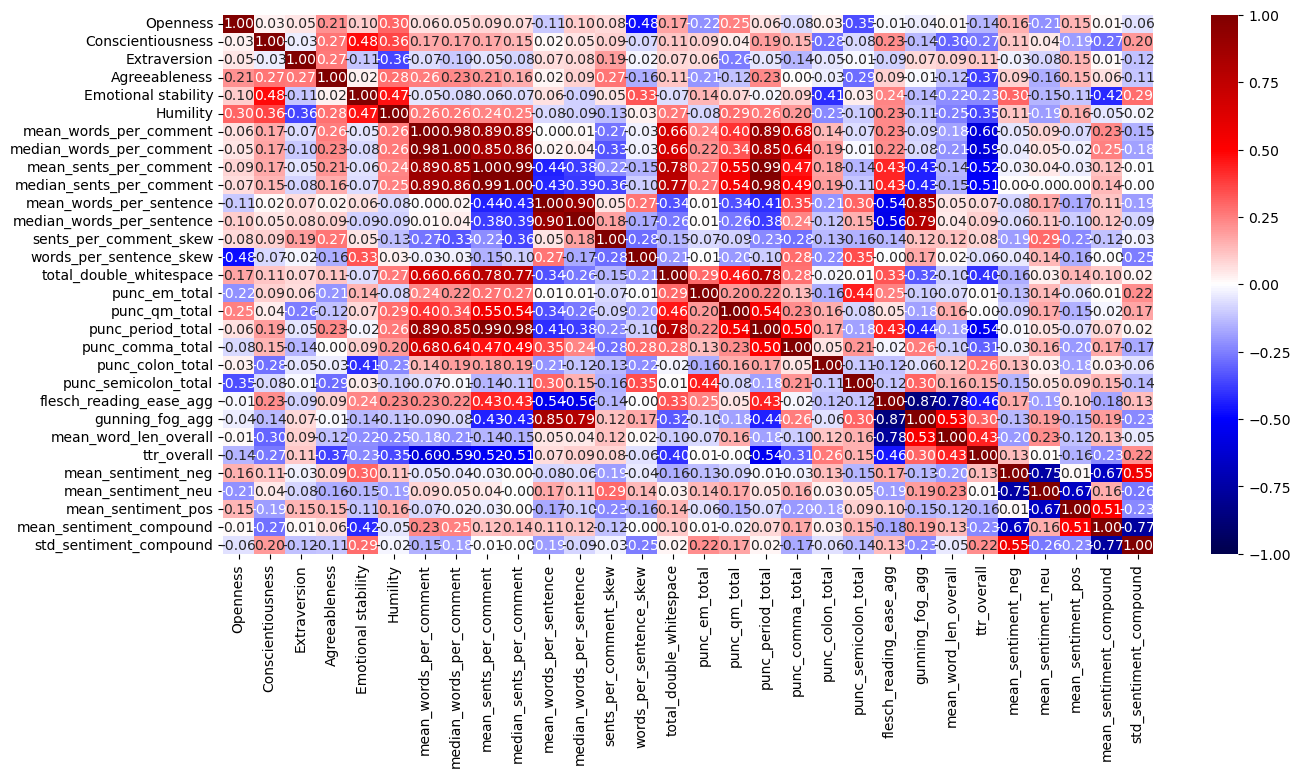

turning into dict
getting q_scores


Device set to use cuda


1/32
2/32
3/32
4/32
5/32
6/32
7/32
8/32
9/32
10/32
11/32
12/32
13/32
14/32
15/32
16/32
17/32
18/32
19/32
20/32
21/32
22/32
23/32
24/32
25/32
26/32
27/32
28/32
29/32
30/32
31/32
32/32
Tokenizing and writing user by user to JSONL file...
Processing user 1/32
Processing user 2/32
Processing user 3/32
Processing user 4/32
Processing user 5/32
Processing user 6/32
Processing user 7/32
Processing user 8/32
Processing user 9/32
Processing user 10/32
Processing user 11/32
Processing user 12/32
Processing user 13/32
Processing user 14/32
Processing user 15/32
Processing user 16/32
Processing user 17/32
Processing user 18/32
Processing user 19/32
Processing user 20/32
Processing user 21/32
Processing user 22/32
Processing user 23/32
Processing user 24/32
Processing user 25/32
Processing user 26/32
Processing user 27/32
Processing user 28/32
Processing user 29/32
Processing user 30/32
Processing user 31/32
Processing user 32/32
Finished processing. Data streamed to val_data.jsonl


In [6]:
val_data = df_preprocess(df_path=r'..\shared task\data\val_data_realvalued.csv')

In [7]:
test_data = df_preprocess(df_path=r'..\shared task\data\test_data_a.csv')


processing test
extracting features
turning into dict
getting q_scores


Device set to use cuda


1/1000
2/1000
3/1000
4/1000
5/1000
6/1000
7/1000
8/1000
9/1000
10/1000
11/1000
12/1000
13/1000
14/1000
15/1000
16/1000
17/1000
18/1000
19/1000
20/1000
21/1000
22/1000
23/1000
24/1000
25/1000
26/1000
27/1000
28/1000
29/1000
30/1000
31/1000
32/1000
33/1000
34/1000
35/1000
36/1000
37/1000
38/1000
39/1000
40/1000
41/1000
42/1000
43/1000
44/1000
45/1000
46/1000
47/1000
48/1000
49/1000
50/1000
51/1000
52/1000
53/1000
54/1000
55/1000
56/1000
57/1000
58/1000
59/1000
60/1000
61/1000
62/1000
63/1000
64/1000
65/1000
66/1000
67/1000
68/1000
69/1000
70/1000
71/1000
72/1000
73/1000
74/1000
75/1000
76/1000
77/1000
78/1000
79/1000
80/1000
81/1000
82/1000
83/1000
84/1000
85/1000
86/1000
87/1000
88/1000
89/1000
90/1000
91/1000
92/1000
93/1000
94/1000
95/1000
96/1000
97/1000
98/1000
99/1000
100/1000
101/1000
102/1000
103/1000
104/1000
105/1000
106/1000
107/1000
108/1000
109/1000
110/1000
111/1000
112/1000
113/1000
114/1000
115/1000
116/1000
117/1000
118/1000
119/1000
120/1000
121/1000
122/1000
123/1000
1

In [ ]:
# clean corr pics

In [ ]:
# topic modeling
    # per author
    # per comment

# training


In [2]:
import json
import torch
from torch.utils.data import IterableDataset
from transformers.tokenization_utils_base import BatchEncoding # For your decode_from_json
import logging
import random
import numpy as np
import torch.nn.functional as F
from transformers import BertModel, BertConfig, get_linear_schedule_with_warmup
from typing import Optional, Tuple, Dict, Union
from torch import nn
import optuna
from torch.utils.data import DataLoader
import gc
from transformers.tokenization_utils_base import BatchEncoding # For type checking and instantiation
import torch.optim as optim
import torch.multiprocessing as mp

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

try:
    mp.set_start_method('spawn', force=True) # or 'forkserver'
    logger.info("Multiprocessing start method set to 'spawn'")
except RuntimeError:
    logger.info("Multiprocessing start method already set or could not be set.")

# --- Constants for marking types in JSON ---
_TENSOR_MARKER = "__tensor__"
_TENSOR_DTYPE_MARKER = "__tensor_dtype__"
_BATCH_ENCODING_MARKER = "__batch_encoding__"
_BATCH_ENCODING_DATA_MARKER = "data"

def _convert_dtype_to_str(dtype):
    """Converts a torch.dtype to a string representation."""
    # This mapping might need to be expanded for other dtypes
    # Alternatively, just use str(dtype) e.g. "torch.int64"
    # and torch.__getattribute__(str_dtype.split('.')[1]) for loading
    return str(dtype)

def _convert_str_to_dtype(dtype_str):
    """Converts a string representation back to a torch.dtype."""
    if not dtype_str.startswith("torch."):
        # Fallback for simple dtype names if str(dtype) was used without "torch." prefix
        # Or if it's a very basic type like 'float32' that torch.dtype can parse
        try:
            return torch.__getattribute__(dtype_str)
        except AttributeError:
            return torch.dtype(dtype_str) # Try direct parsing

    # For strings like "torch.int64"
    dtype_name = dtype_str.split('.')[1]
    return torch.__getattribute__(dtype_name)


def _recursive_encode(obj):
    """
    Recursively traverses the object and converts tensors and BatchEncoding
    to JSON-serializable representations.
    """
    if isinstance(obj, torch.Tensor):
        return {
            _TENSOR_MARKER: True,
            _BATCH_ENCODING_DATA_MARKER: obj.tolist(),
            _TENSOR_DTYPE_MARKER: _convert_dtype_to_str(obj.dtype)
        }
    elif isinstance(obj, BatchEncoding):
        # BatchEncoding is dict-like. We need to encode its items.
        # We also mark that this dictionary was originally a BatchEncoding.
        return {
            _BATCH_ENCODING_MARKER: True,
            _BATCH_ENCODING_DATA_MARKER: {k: _recursive_encode(v) for k, v in obj.items()}
        }
    elif isinstance(obj, dict):
        return {k: _recursive_encode(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [_recursive_encode(item) for item in obj]
    # Add other custom types here if needed
    return obj # For primitive types

def encode_for_json(data_to_encode):
    """
    Encodes data containing PyTorch tensors and BatchEncoding objects
    into a JSON-serializable format.
    """
    return _recursive_encode(data_to_encode)

def _json_object_hook(dct):
    """
    Object hook for json.load or json.loads to reconstruct
    tensors and BatchEncoding objects.
    """
    if _TENSOR_MARKER in dct:
        dtype_str = dct.get(_TENSOR_DTYPE_MARKER, 'float32') # Default to float32 if not found
        dtype = _convert_str_to_dtype(dtype_str)
        return torch.tensor(dct[_BATCH_ENCODING_DATA_MARKER], dtype=dtype)
    elif _BATCH_ENCODING_MARKER in dct:
        # The items within dct['data'] should have already been processed
        # by this hook if they were tensors or other BatchEncodings.
        return BatchEncoding(dct[_BATCH_ENCODING_DATA_MARKER])
    return dct # Return dict as is if not a special type

def decode_from_json(json_data):
    """
    Decodes JSON data (string or file pointer) back into Python objects,
    reconstructing PyTorch tensors and BatchEncoding objects.
    
    :param json_data: JSON string or a file-like object (e.g., opened file).
    """
    if isinstance(json_data, str):
        return json.loads(json_data, object_hook=_json_object_hook)
    else: # Assuming file-like object
        return json.load(json_data, object_hook=_json_object_hook)
    

#for loading train
def _convert_str_to_dtype(dtype_str):
    if not dtype_str.startswith("torch."):
        try:
            return torch.__getattribute__(dtype_str)
        except AttributeError:
            return torch.dtype(dtype_str)
    dtype_name = dtype_str.split('.')[1]
    return torch.__getattribute__(dtype_name)

def _json_object_hook_for_dataset(dct):
    """
    Object hook for json.load or json.loads to reconstruct
    tensors and BatchEncoding objects from your streamed JSONL.
    """
    if _TENSOR_MARKER in dct:
        dtype_str = dct.get(_TENSOR_DTYPE_MARKER, 'float32')
        dtype = _convert_str_to_dtype(dtype_str)
        # Data is expected to be list of lists for tensors from your encode_for_json
        return torch.tensor(dct[_BATCH_ENCODING_DATA_MARKER], dtype=dtype)
    elif _BATCH_ENCODING_MARKER in dct:
        # dct[_BATCH_ENCODING_DATA_MARKER] should be a dict where values might be tensors
        # (already processed by this hook) or lists of lists that need to become tensors.
        # Your PersonalityDatasetV3 expects 'input_ids', etc. to be tensors directly.
        
        # If your encode_for_json's fallback for BatchEncoding (when torch.cat failed)
        # stored raw lists of lists like:
        # "comments_tokenized": {
        #     "__batch_encoding__": True,
        #     "data": {
        #         "input_ids": [[...], [...]], # list of lists of ints
        #         "token_type_ids": [[...], [...]],
        #         "attention_mask": [[...], [...]]
        #     }
        # }
        # Then we need to convert these lists to tensors here.
        
        # If your encode_for_json stored tensors (which became lists of lists in JSON),
        # and your concatenated tensors were successful, the structure would be like:
        # "comments_tokenized": {
        #     "__batch_encoding__": True,
        #     "data": {
        #         "input_ids": <torch.Tensor reconstructed from list-of-lists>,
        #         "token_type_ids": <torch.Tensor ...>,
        #         "attention_mask": <torch.Tensor ...>
        #     }
        # }
        # In this case, BatchEncoding(dct[_BATCH_ENCODING_DATA_MARKER]) works.
        
        # Let's assume the latter (tensors are already reconstructed within dct[_BATCH_ENCODING_DATA_MARKER])
        # or that your PersonalityDatasetV3 will handle the conversion if it sees lists.
        # Given your dataset expects `tokenized_info['input_ids']` to be a tensor,
        # it's best if the hook ensures this.

        reconstructed_batch_data = {}
        for k, v_data in dct[_BATCH_ENCODING_DATA_MARKER].items():
            if isinstance(v_data, list) and k in ["input_ids", "token_type_ids", "attention_mask"]:
                # This handles the case where the data for input_ids (etc.)
                # was stored as a list of lists (e.g. from tensor.tolist())
                # and needs to be converted back to a single tensor.
                try:
                    # Assuming common dtypes for these fields
                    dtype = torch.long if k == "input_ids" or k == "token_type_ids" else torch.long # attention_mask usually bool or long
                    reconstructed_batch_data[k] = torch.tensor(v_data, dtype=dtype)
                except Exception as e:
                    # logger.error(f"Error converting {k} to tensor in _json_object_hook_for_dataset: {e}")
                    reconstructed_batch_data[k] = v_data # Keep as list if tensor conversion fails
            else:
                reconstructed_batch_data[k] = v_data # Already a tensor or other data type
        
        return BatchEncoding(reconstructed_batch_data)
    return dct

def load_data_from_jsonl(file_path):
    data_list = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f):
            try:
                # Apply the hook to each JSON object (line)
                data_item = json.loads(line, object_hook=_json_object_hook_for_dataset)
                data_list.append(data_item)
            except json.JSONDecodeError as e:
                logger.error(f"Error decoding JSON on line {line_num+1} in {file_path}: {e}")
            except Exception as e_hook:
                logger.error(f"Error in object_hook on line {line_num+1} in {file_path}: {e_hook}")

    return data_list

c:\Users\User\.local\share\mamba\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-01 06:05:34,820 - INFO - Multiprocessing start method set to 'spawn'


In [3]:


logger = logging.getLogger(__name__) # Or use existing logger

# --- Constants for JSON (ensure these match what you used when saving) ---
_TENSOR_MARKER = "__tensor__"
_TENSOR_DTYPE_MARKER = "__tensor_dtype__"
_BATCH_ENCODING_MARKER = "__batch_encoding__"
_BATCH_ENCODING_DATA_MARKER = "data" # Make sure this matches what was saved

def _convert_str_to_dtype(dtype_str: str) -> torch.dtype:
    """Converts a string representation back to a torch.dtype."""
    if not dtype_str.startswith("torch."):
        try:
            return torch.__getattribute__(dtype_str) # e.g. "float32"
        except AttributeError:
            return torch.dtype(dtype_str) # Try direct parsing
    dtype_name = dtype_str.split('.')[1] # e.g., "torch.int64" -> "int64"
    return torch.__getattribute__(dtype_name)

def _json_object_hook_for_dataset(dct: dict) -> any:
    """
    Object hook for json.loads to reconstruct tensors and BatchEncoding objects.
    """
    if _TENSOR_MARKER in dct:
        dtype_str = dct.get(_TENSOR_DTYPE_MARKER, 'float32') # Default dtype
        dtype = _convert_str_to_dtype(dtype_str)
        # Data from tensor.tolist() is a list of lists (or list for 1D)
        return torch.tensor(dct[_BATCH_ENCODING_DATA_MARKER], dtype=dtype)
    elif _BATCH_ENCODING_MARKER in dct:
        # The 'data' part of BatchEncoding should be a dictionary.
        # Its values (like input_ids) should have been converted to tensors
        # by this hook if they were marked as tensors.
        reconstructed_data_for_be = {}
        batch_encoding_payload = dct.get(_BATCH_ENCODING_DATA_MARKER, {})
        for k, v_data in batch_encoding_payload.items():
            # If v_data is a list (e.g., input_ids was list of lists from tolist())
            # and wasn't explicitly marked as a __tensor__ itself, convert it now.
            # This typically happens if the BatchEncoding's internal tensors were directly converted to lists.
            if isinstance(v_data, list) and k in ["input_ids", "token_type_ids", "attention_mask"]:
                try:
                    # Determine dtype (input_ids, token_type_ids are usually long)
                    tensor_dtype = torch.long if k in ["input_ids", "token_type_ids"] else torch.long # attention_mask can be long or bool
                    reconstructed_data_for_be[k] = torch.tensor(v_data, dtype=tensor_dtype)
                except Exception as e:
                    logger.error(f"Error converting field '{k}' in BatchEncoding to tensor: {e}. Keeping as list.")
                    reconstructed_data_for_be[k] = v_data # Fallback
            else:
                reconstructed_data_for_be[k] = v_data # Already a tensor or primitive
        return BatchEncoding(reconstructed_data_for_be)
    return dct

class JsonlIterableDataset(IterableDataset):
    def __init__(self, file_path, trait_names, n_comments_to_process,
                other_numerical_feature_names, num_q_features_per_comment,
                expected_seq_len, # <<< ADD THIS
                is_test_set=False, transform_fn=None):
        super().__init__()
        self.file_path = file_path
        self.trait_names_ordered = trait_names
        self.n_comments_to_process = n_comments_to_process
        self.other_numerical_feature_names = other_numerical_feature_names
        self.num_q_features_per_comment = num_q_features_per_comment
        self.expected_seq_len = expected_seq_len # <<< STORE IT
        self.is_test_set = is_test_set
        self.transform_fn = self._default_transform if transform_fn is None else transform_fn

    def _default_transform(self, sample, original_line_idx):
        # --- 1. Tokenized Comments ---
        # Safely get tokenized_info and its components
        tokenized_info = sample.get('features', {}).get('comments_tokenized', {})
        all_input_ids = tokenized_info.get('input_ids')
        all_attention_mask = tokenized_info.get('attention_mask')

        num_actual_comments = 0
        # Use the passed-in expected_seq_len
        sequence_length = self.expected_seq_len

        if all_input_ids is not None and isinstance(all_input_ids, torch.Tensor):
            if all_input_ids.ndim == 2: # Expected: (num_comments, seq_len)
                num_actual_comments = all_input_ids.shape[0]
                if num_actual_comments > 0:
                    # Override sequence_length if we have actual comments and a valid shape
                    # This allows for variable sequence lengths if your data isn't uniformly padded
                    # BUT if it IS uniformly padded, self.expected_seq_len should match all_input_ids.shape[1]
                    current_seq_len = all_input_ids.shape[1]
                    if current_seq_len != self.expected_seq_len:
                        logger.warning(
                            f"Sample (line approx {original_line_idx}): Mismatch between expected_seq_len ({self.expected_seq_len}) "
                            f"and actual sequence length from input_ids ({current_seq_len}). Using actual: {current_seq_len}."
                            "This might cause batching issues if not all samples have this length."
                        )
                        sequence_length = current_seq_len # Or decide to enforce self.expected_seq_len
                    else:
                        sequence_length = current_seq_len

                    if sequence_length == 0:
                        logger.warning(f"Sample (line approx {original_line_idx}): Loaded comments but seq_len is 0. Defaulting to expected {self.expected_seq_len}.")
                        sequence_length = self.expected_seq_len
            elif all_input_ids.ndim == 1 and all_input_ids.shape[0] == 0: # Handles torch.tensor([])
                num_actual_comments = 0 # sequence_length remains self.expected_seq_len
            else:
                logger.warning(f"Sample (line approx {original_line_idx}): 'input_ids' has unexpected ndim {all_input_ids.ndim} or shape {all_input_ids.shape}. Treating as 0 comments.")
                num_actual_comments = 0 # sequence_length remains self.expected_seq_len
        else:
            logger.warning(f"Sample (line approx {original_line_idx}): 'input_ids' missing or not a tensor. Treating as 0 comments.")
            num_actual_comments = 0 # sequence_length remains self.expected_seq_len

        # Defensive check for all_attention_mask
        if all_attention_mask is None or not isinstance(all_attention_mask, torch.Tensor) or \
        all_attention_mask.shape[0] != num_actual_comments or \
        (num_actual_comments > 0 and (all_attention_mask.ndim != 2 or all_attention_mask.shape[1] != sequence_length)) or \
        (num_actual_comments == 0 and not ((all_attention_mask.ndim == 2 and all_attention_mask.shape[0] == 0 and all_attention_mask.shape[1] == sequence_length) or \
                                            (all_attention_mask.ndim == 1 and all_attention_mask.shape[0] == 0))):
            logger.warning(f"Sample (line approx {original_line_idx}): 'attention_mask' missing, malformed, or inconsistent with 'input_ids'. Creating a default based on input_ids (if available) or zeros.")
            if num_actual_comments > 0 and all_input_ids is not None and all_input_ids.ndim == 2:
                all_attention_mask = torch.ones_like(all_input_ids) # Default to all ones if input_ids exists
            else: # Default for 0 actual comments or unusable input_ids
                all_attention_mask = torch.empty(0, sequence_length, dtype=torch.long) # This will be (0, D)

        # Create placeholder tensors
        final_input_ids = torch.zeros((self.n_comments_to_process, sequence_length), dtype=torch.long)
        final_attention_mask = torch.zeros((self.n_comments_to_process, sequence_length), dtype=torch.long)
        comment_active_flags = torch.zeros(self.n_comments_to_process, dtype=torch.bool)

        indices_to_select = list(range(num_actual_comments))
        if num_actual_comments > self.n_comments_to_process:
            indices_to_select = random.sample(indices_to_select, self.n_comments_to_process)
        # comments_to_fill is the number of comments we will actually place into the tensors
        comments_to_fill = min(num_actual_comments, self.n_comments_to_process)

        for i in range(comments_to_fill):
            original_comment_idx = indices_to_select[i] # Index in the original `all_input_ids`

            # Ensure the source tensor has the expected sequence_length for this comment
            current_comment_input_ids = all_input_ids[original_comment_idx]
            current_comment_attn_mask = all_attention_mask[original_comment_idx]

            # This copy assumes current_comment_input_ids is 1D (seq_len,)
            # If sequence_length from data was different from self.expected_seq_len, padding/truncation might be needed here
            # For simplicity, assuming they match or data is already padded/truncated to sequence_length
            final_input_ids[i, :sequence_length] = current_comment_input_ids[:sequence_length]
            final_attention_mask[i, :sequence_length] = current_comment_attn_mask[:sequence_length]
            comment_active_flags[i] = True

        # --- 2. Q-Scores ---
        raw_q_scores = sample.get('features', {}).get('q_scores', [])
        final_q_scores = torch.zeros((self.n_comments_to_process, self.num_q_features_per_comment), dtype=torch.float)

        # Iterate for the number of comments we are actually processing for the model
        for i in range(comments_to_fill):
            original_comment_idx = indices_to_select[i] # Index in the original q_scores list

            if original_comment_idx < len(raw_q_scores):
                q_score_values_for_comment = raw_q_scores[original_comment_idx]
                try:
                    if isinstance(q_score_values_for_comment, list):
                        # Pad or truncate q_score_values_for_comment if its length is not self.num_q_features_per_comment
                        padded_q_scores = q_score_values_for_comment[:self.num_q_features_per_comment] + \
                                        [0.0] * (self.num_q_features_per_comment - len(q_score_values_for_comment))
                        final_q_scores[i] = torch.tensor(padded_q_scores[:self.num_q_features_per_comment], dtype=torch.float)
                    else:
                        logger.warning(f"Sample (line approx {original_line_idx}): q_score for original_idx {original_comment_idx} is not a list: {q_score_values_for_comment}. Using zeros.")
                except (TypeError, ValueError) as e:
                    logger.warning(f"Sample (line approx {original_line_idx}): Error converting q_score for original_idx {original_comment_idx} to tensor: {q_score_values_for_comment}. Error: {e}. Using zeros.")
            # else: q_score for this original comment index is missing, final_q_scores[i] remains zeros.

        # --- 3. Other Numerical Features ---
        other_numerical_features_list = []
        # Make sure self.other_numerical_feature_names exists and is correct
        for fname in self.other_numerical_feature_names:
            val = sample.get('features', {}).get(fname, 0.0)
            try:
                other_numerical_features_list.append(float(val))
            except (ValueError, TypeError):
                logger.warning(f"Could not convert numerical feature '{fname}' (value: {val}) for sample (line approx {original_line_idx}). Using 0.0.")
                other_numerical_features_list.append(0.0)
        other_numerical_features_tensor = torch.tensor(other_numerical_features_list, dtype=torch.float)

        # --- 4. Labels ---
        if not self.is_test_set:
            labels_dict = sample.get('labels', {})
            regression_labels = []
            for trait_key in self.trait_names_ordered:
                label_val = labels_dict.get(trait_key.title(), labels_dict.get(trait_key, 0.0))
                try:
                    label_float = float(label_val)
                    if not (0.0 <= label_float <= 1.0):
                        label_float = np.clip(label_float, 0.0, 1.0)
                    regression_labels.append(label_float)
                except (ValueError, TypeError):
                    logger.error(f"Invalid label value for trait {trait_key}: {label_val}. Using 0.0 for sample (line approx {original_line_idx}).")
                    regression_labels.append(0.0)
            labels_tensor = torch.tensor(regression_labels, dtype=torch.float)
            return (final_input_ids, final_attention_mask, final_q_scores, comment_active_flags, other_numerical_features_tensor, labels_tensor)
        else:
            return (final_input_ids, final_attention_mask, final_q_scores, comment_active_flags, other_numerical_features_tensor)

    # In JsonlIterableDataset class:
    def __iter__(self):
        # Each call to __iter__ should produce a new, independent iterator.
        # This is especially important for persistent workers.
        try:
            file_handle = open(self.file_path, 'r', encoding='utf-8')
        except FileNotFoundError:
            logger.error(f"File not found when creating iterator: {self.file_path}")
            return iter([]) # Return an empty iterator

        worker_info = torch.utils.data.get_worker_info()

        if worker_info is None:  # Single-process data loading
            # logger.debug(f"JsonlIterableDataset: Running in single-process mode for {self.file_path}")
            for line_num, line in enumerate(file_handle):
                processed_item = self._process_line(line, line_num) # Pass line_num for better logging
                if processed_item is not None:
                    yield processed_item
        else:  # Multi-process data loading
            worker_id = worker_info.id
            num_workers = worker_info.num_workers
            # logger.debug(f"JsonlIterableDataset: Worker {worker_id}/{num_workers} starting for {self.file_path}")
            for i, line in enumerate(file_handle):
                if i % num_workers == worker_id:
                    processed_item = self._process_line(line, i) # Pass line index i for logging
                    if processed_item is not None:
                        yield processed_item
        
        # logger.debug(f"JsonlIterableDataset: Worker {worker_id if worker_info else 'main'} finished iterating {self.file_path}")
        file_handle.close()

    # Modify _process_line to accept line_num for logging
    def _process_line(self, line, line_num_for_logging):
        try:
            sample_data = json.loads(line, object_hook=_json_object_hook_for_dataset)
        except json.JSONDecodeError as e:
            logger.error(f"JSON parsing error in {self.file_path} (line approx {line_num_for_logging+1}): {e} on line content: {line[:200]}")
            return None
        
        try:
            # Assuming self.transform_fn is _default_transform which takes (sample, idx)
            # Pass line_num_for_logging as idx for more specific error messages from transform
            return self.transform_fn(sample_data, line_num_for_logging)
        except Exception as e_transform:
            logger.error(f"Error in transform_fn for {self.file_path} (line approx {line_num_for_logging+1}): {e_transform} for sample data (first 200 chars of line): {line[:200]}", exc_info=True)
            # You could re-raise here if you want the DataLoader to hard stop on bad data
            # raise 
            return None # Skip bad sample



# --- PersonalityModelV3 (Regression and q_scores integration) ---
class PersonalityModelV3(nn.Module):
    def __init__(self,
                 bert_model_name: str,
                 num_traits: int,
                 n_comments_to_process: int = 3,
                 dropout_rate: float = 0.2,
                 attention_hidden_dim: int = 128,
                 num_bert_layers_to_pool: int = 4,
                 num_q_features_per_comment: int = 3, # For Q1, Q2, Q3 scores per comment
                 num_other_numerical_features: int = 0, # From sample['features'] excluding q_scores
                 numerical_embedding_dim: int = 64
                ):
        super().__init__()
        self.bert_config = BertConfig.from_pretrained(bert_model_name, output_hidden_states=True)
        self.bert = BertModel.from_pretrained(bert_model_name, config=self.bert_config)
        self.n_comments_to_process = n_comments_to_process
        self.num_bert_layers_to_pool = num_bert_layers_to_pool
        bert_hidden_size = self.bert.config.hidden_size
        self.num_q_features_per_comment = num_q_features_per_comment

        # Comment processing part (BERT embedding + q_scores)
        comment_feature_dim = bert_hidden_size + self.num_q_features_per_comment
        self.attention_w = nn.Linear(comment_feature_dim, attention_hidden_dim)
        self.attention_v = nn.Linear(attention_hidden_dim, 1, bias=False)
        
        self.dropout = nn.Dropout(dropout_rate)

        # Other numerical features processing part (from sample['features'])
        self.num_other_numerical_features = num_other_numerical_features
        self.uses_other_numerical_features = self.num_other_numerical_features > 0
        self.other_numerical_processor_output_dim = 0

        # Dimension of aggregated comment features (output of attention over comment_feature_dim)
        aggregated_comment_feature_dim = comment_feature_dim 
        combined_input_dim_for_heads = aggregated_comment_feature_dim

        if self.uses_other_numerical_features:
            self.other_numerical_processor_output_dim = numerical_embedding_dim
            self.other_numerical_processor = nn.Sequential(
                nn.Linear(self.num_other_numerical_features, self.other_numerical_processor_output_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            combined_input_dim_for_heads += self.other_numerical_processor_output_dim
            logger.info(f"Model will use {self.num_other_numerical_features} other numerical features, processed to dim {self.other_numerical_processor_output_dim}.")
        else:
            logger.info("Model will NOT use other numerical features.")

        # Trait regression heads
        self.trait_regressors = nn.ModuleList()
        for _ in range(num_traits):
            self.trait_regressors.append(
                nn.Linear(combined_input_dim_for_heads, 1) # Output one value per trait
            )

    def _pool_bert_layers(self, all_hidden_states: Tuple[torch.Tensor, ...], attention_mask: torch.Tensor) -> torch.Tensor:
        # Assuming all_hidden_states contains embeddings for all layers
        # The last 'num_bert_layers_to_pool' layers are averaged.
        # Or, more commonly, take the [CLS] token embedding from the last few layers or just the last layer.
        # Your current pooling averages token embeddings for selected layers. Let's keep it for now.
        
        layers_to_pool = all_hidden_states[-self.num_bert_layers_to_pool:]
        pooled_outputs = []
        expanded_attention_mask = attention_mask.unsqueeze(-1).expand_as(layers_to_pool[0]) # (batch*n_comments, seq_len, hidden_size)
        
        for layer_hidden_states in layers_to_pool:
            # Masked average pooling
            sum_embeddings = torch.sum(layer_hidden_states * expanded_attention_mask, dim=1) # (batch*n_comments, hidden_size)
            sum_mask = expanded_attention_mask.sum(dim=1) # (batch*n_comments, hidden_size)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            pooled_outputs.append(sum_embeddings / sum_mask) # Element-wise division
            
        stacked_pooled_outputs = torch.stack(pooled_outputs, dim=0) # (num_pool_layers, batch*n_comments, hidden_size)
        mean_pooled_layers_embedding = torch.mean(stacked_pooled_outputs, dim=0) # (batch*n_comments, hidden_size)
        return mean_pooled_layers_embedding


    def forward(self,
                input_ids: torch.Tensor,      # (batch_size, n_comments, seq_len)
                attention_mask: torch.Tensor, # (batch_size, n_comments, seq_len)
                q_scores: torch.Tensor,       # (batch_size, n_comments, num_q_features)
                comment_active_mask: torch.Tensor, # (batch_size, n_comments)
                other_numerical_features: Optional[torch.Tensor] = None # (batch_size, num_other_num_features)
               ):
        batch_size = input_ids.shape[0]
        
        # Flatten for BERT: (batch_size * n_comments, seq_len)
        input_ids_flat = input_ids.view(-1, input_ids.shape[-1])
        attention_mask_flat = attention_mask.view(-1, attention_mask.shape[-1])
        
        bert_outputs = self.bert(input_ids=input_ids_flat, attention_mask=attention_mask_flat)
        # bert_last_hidden_state = bert_outputs.last_hidden_state # (batch*n_comments, seq_len, bert_hidden_size)
        # Pooled BERT embeddings for each comment
        # comment_bert_embeddings_flat = bert_last_hidden_state[:, 0, :] # Using [CLS] token
        comment_bert_embeddings_flat = self._pool_bert_layers(bert_outputs.hidden_states, attention_mask_flat)


        # Reshape back to (batch_size, n_comments, bert_hidden_size)
        comment_bert_embeddings = comment_bert_embeddings_flat.view(batch_size, self.n_comments_to_process, -1)
        
        # Concatenate q_scores with BERT embeddings for each comment
        # q_scores is (batch_size, n_comments, num_q_features)
        comment_features_with_q = torch.cat((comment_bert_embeddings, q_scores), dim=2)
        
        # Attention over combined comment features
        # comment_features_with_q shape: (batch_size, n_comments, bert_hidden_size + num_q_features)
        u = torch.tanh(self.attention_w(comment_features_with_q)) # (batch_size, n_comments, attention_hidden_dim)
        scores = self.attention_v(u).squeeze(-1) # (batch_size, n_comments)
        
        if comment_active_mask is not None:
            scores = scores.masked_fill(~comment_active_mask, -1e9) # Apply mask before softmax
            
        attention_weights = F.softmax(scores, dim=1) # (batch_size, n_comments)
        attention_weights_expanded = attention_weights.unsqueeze(-1) # (batch_size, n_comments, 1)
        
        # Weighted sum of comment_features_with_q
        aggregated_comment_features = torch.sum(attention_weights_expanded * comment_features_with_q, dim=1)
        # aggregated_comment_features shape: (batch_size, bert_hidden_size + num_q_features)

        final_features_for_heads = aggregated_comment_features
        if self.uses_other_numerical_features:
            if other_numerical_features is None or other_numerical_features.shape[1] != self.num_other_numerical_features:
                raise ValueError(
                    f"Other numerical features expected but not provided correctly. "
                    f"Expected {self.num_other_numerical_features}, got shape {other_numerical_features.shape if other_numerical_features is not None else 'None'}"
                )
            processed_other_numerical_features = self.other_numerical_processor(other_numerical_features)
            final_features_for_heads = torch.cat((aggregated_comment_features, processed_other_numerical_features), dim=1)
        
        combined_features_dropped = self.dropout(final_features_for_heads)
        
        trait_regression_outputs = []
        for regressor_head in self.trait_regressors:
            trait_regression_outputs.append(regressor_head(combined_features_dropped))
        
        # Concatenate outputs for all traits: (batch_size, num_traits)
        all_trait_outputs_raw = torch.cat(trait_regression_outputs, dim=1)
        
        # Apply sigmoid to constrain output to [0, 1] for regression
        all_trait_outputs_sigmoid = torch.sigmoid(all_trait_outputs_raw)
        
        return all_trait_outputs_sigmoid

    def predict_scores(self, outputs: torch.Tensor) -> torch.Tensor:
        # The forward pass already returns the sigmoid-activated scores
        return outputs



# --- Optuna Objective Function (MODIFIED for Regression) ---
def objective(trial: optuna.trial.Trial,
              # REMOVE: train_data_list: List[Dict],
              # REMOVE: val_data_list: List[Dict],
              # ADD file paths if you want to pass them, or use global constants
              train_file_path: str,
              val_file_path: str,
              global_config: Dict,
              device: torch.device,
              num_epochs_per_trial: int = 10):
    logger.info(f"Starting Optuna Trial {trial.number}")

    num_traits = len(global_config['TRAIT_NAMES'])
    other_numerical_feature_names_trial = global_config.get('OTHER_NUMERICAL_FEATURE_NAMES', [])
    num_other_numerical_features_trial = len(other_numerical_feature_names_trial)
    num_q_features_per_comment_trial = global_config.get('NUM_Q_FEATURES_PER_COMMENT', 3)

    # --- Suggest Hyperparameters ---
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.4) # Adjusted range
    attention_hidden_dim = trial.suggest_categorical("attention_hidden_dim", [128, 256, 512]) # Larger options
    lr_bert = trial.suggest_float("lr_bert", 5e-6, 1e-4, log=True) # Adjusted range
    lr_head = trial.suggest_float("lr_head", 1e-4, 1e-2, log=True) # Adjusted range
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True) # Adjusted range
    num_bert_layers_to_pool = trial.suggest_int("num_bert_layers_to_pool", 1, 4)
    n_comments_trial = trial.suggest_int("n_comments_to_process", 1, global_config.get('MAX_COMMENTS_TO_PROCESS_PHYSICAL', 3)) # Max based on data
    num_unfrozen_bert_layers = trial.suggest_int("num_unfrozen_bert_layers", 0, 6) # Fewer unfrozen layers often better
    patience_early_stopping = trial.suggest_int("patience_early_stopping", 3, 5)
    scheduler_type = trial.suggest_categorical("scheduler_type", ["none", "linear_warmup"])
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.05, 0.2) if scheduler_type != "none" else 0.0
    batch_size_trial = trial.suggest_categorical("batch_size", [8, 16]) # Kept smaller due to BERT

    other_numerical_embedding_dim_trial = 0
    if num_other_numerical_features_trial > 0:
        other_numerical_embedding_dim_trial = trial.suggest_categorical("other_numerical_embedding_dim", [32, 64])

    logger.info(f"Trial {trial.number} - Suggested Parameters: {trial.params}")
    try:
        logger.info(f"Trial {trial.number} - Loading data from: {train_file_path}, {val_file_path}")
        train_dataset_trial = JsonlIterableDataset(
                file_path=train_file_path,
                trait_names=global_config['TRAIT_NAMES_ORDERED'],
                n_comments_to_process=n_comments_trial,
                other_numerical_feature_names=other_numerical_feature_names_trial,
                num_q_features_per_comment=num_q_features_per_comment_trial,
                expected_seq_len=global_config.get('TOKENIZER_MAX_LENGTH', 512), # <<< PASS IT HERE
                is_test_set=False
        )
        val_dataset_trial = JsonlIterableDataset(
            file_path=val_file_path,
            trait_names=global_config['TRAIT_NAMES_ORDERED'],
            n_comments_to_process=n_comments_trial,
            other_numerical_feature_names=other_numerical_feature_names_trial,
            num_q_features_per_comment=num_q_features_per_comment_trial,
            expected_seq_len=global_config.get('TOKENIZER_MAX_LENGTH', 512), # <<< PASS IT HERE
            is_test_set=False
        )
        # For IterableDataset, shuffle is not a parameter.
        # num_workers > 0 can be tricky with IterableDatasets if not designed carefully. Start with 0.
        train_loader_trial = DataLoader(train_dataset_trial, batch_size=batch_size_trial, num_workers=7, pin_memory=True if device.type == 'cuda' else False, persistent_workers=True)
        val_loader_trial = DataLoader(val_dataset_trial, batch_size=batch_size_trial, num_workers=7, pin_memory=True if device.type == 'cuda' else False, persistent_workers=True)
    except Exception as e:
        logger.error(f"Trial {trial.number} - Error creating dataset/dataloader: {e}", exc_info=True)
        return float('inf')

    model = PersonalityModelV3(
        bert_model_name=global_config['BERT_MODEL_NAME'],
        num_traits=num_traits,
        n_comments_to_process=n_comments_trial,
        dropout_rate=dropout_rate,
        attention_hidden_dim=attention_hidden_dim,
        num_bert_layers_to_pool=num_bert_layers_to_pool,
        num_q_features_per_comment=num_q_features_per_comment_trial,
        num_other_numerical_features=num_other_numerical_features_trial,
        numerical_embedding_dim=other_numerical_embedding_dim_trial
    ).to(device)

    # BERT Layer Freezing
    for name, param in model.bert.named_parameters(): param.requires_grad = False # Freeze all initially
    if num_unfrozen_bert_layers > 0:
        if hasattr(model.bert, 'embeddings'):
            for param in model.bert.embeddings.parameters(): param.requires_grad = True
        
        actual_layers_to_unfreeze = min(num_unfrozen_bert_layers, model.bert.config.num_hidden_layers)
        for i in range(model.bert.config.num_hidden_layers - actual_layers_to_unfreeze, model.bert.config.num_hidden_layers):
            if i >= 0:
                for param in model.bert.encoder.layer[i].parameters(): param.requires_grad = True
        
        if hasattr(model.bert, 'pooler') and model.bert.pooler is not None: # Though pooler is often not used for seq classification
            for param in model.bert.pooler.parameters(): param.requires_grad = True
    
    logger.debug(f"Trial {trial.number} - BERT params requiring grad: "
                 f"{sum(p.numel() for p in model.bert.parameters() if p.requires_grad)}")

    # Optimizer Setup
    optimizer_grouped_parameters = []
    bert_params_to_tune = [p for p in model.bert.parameters() if p.requires_grad]
    if bert_params_to_tune and lr_bert > 0:
         optimizer_grouped_parameters.append({"params": bert_params_to_tune, "lr": lr_bert, "weight_decay": 0.01}) # Different WD for BERT

    head_params = list(model.attention_w.parameters()) + list(model.attention_v.parameters())
    for regressor_head in model.trait_regressors:
        head_params.extend(list(regressor_head.parameters()))
    if model.uses_other_numerical_features:
        head_params.extend(list(model.other_numerical_processor.parameters()))
    
    optimizer_grouped_parameters.append({"params": head_params, "lr": lr_head, "weight_decay": weight_decay}) # Main WD for head
        
    if not any(pg['params'] for pg in optimizer_grouped_parameters if pg['params']): # Check if any group has params
        logger.warning(f"Trial {trial.number} - No parameters to optimize. Skipping training.")
        return float('inf') # Return high loss for minimization

    optimizer = optim.AdamW(optimizer_grouped_parameters) # WD applied per group
    
    # set schedule
    scheduler = None
    if scheduler_type == "linear_warmup":
        # Calculate num_training_steps using the pre-counted samples
        if global_config.get('NUM_TRAIN_SAMPLES', 0) > 0: # Check if count is available
            num_batches_per_epoch = (global_config['NUM_TRAIN_SAMPLES'] + batch_size_trial - 1) // batch_size_trial # Ceiling division
            num_training_steps = num_batches_per_epoch * num_epochs_per_trial
            num_warmup_steps = int(num_training_steps * warmup_ratio)
            if num_warmup_steps > 0 and num_training_steps > 0:
                scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
            else:
                logger.warning(f"Trial {trial.number}: Calculated num_warmup_steps or num_training_steps is zero. Scheduler not created. Warmup: {num_warmup_steps}, Training: {num_training_steps}")
        else:
            logger.warning(f"Trial {trial.number}: NUM_TRAIN_SAMPLES not available or zero in global_config. Cannot create linear_warmup scheduler.")


    # Regression loss
    loss_fn = nn.MSELoss().to(device) # Or nn.L1Loss()
    best_trial_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs_per_trial):
        model.train()
        total_train_loss = 0
        for batch_idx, batch_tuple in enumerate(train_loader_trial):
            input_ids, attention_m, q_s, comment_active_m, other_num_feats, labels_reg = [b.to(device) for b in batch_tuple]
            
            optimizer.zero_grad()
            predicted_scores = model(input_ids, attention_m, q_s, comment_active_m, other_num_feats)
            
            current_batch_loss = loss_fn(predicted_scores, labels_reg)
            
            if torch.isnan(current_batch_loss) or torch.isinf(current_batch_loss):
                logger.warning(f"Trial {trial.number}, Epoch {epoch+1}, Batch {batch_idx}: NaN or Inf loss detected. Skipping batch.")
                torch.cuda.empty_cache()
                continue

            current_batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            if scheduler: scheduler.step()
            total_train_loss += current_batch_loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader_trial) if len(train_loader_trial) > 0 else float('inf')
        logger.info(f"Trial {trial.number}, Epoch {epoch+1}/{num_epochs_per_trial} completed. Avg Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        current_epoch_val_loss = 0
        all_val_preds_epoch = []
        all_val_labels_epoch = []
        with torch.no_grad():
            for batch_tuple in val_loader_trial:
                input_ids, attention_m, q_s, comment_active_m, other_num_feats, labels_reg = [b.to(device) for b in batch_tuple]
                if input_ids.numel() == 0: continue
                
                predicted_scores = model(input_ids, attention_m, q_s, comment_active_m, other_num_feats)
                if predicted_scores.numel() == 0: continue
                
                batch_val_loss = loss_fn(predicted_scores, labels_reg)
                current_epoch_val_loss += batch_val_loss.item()
                all_val_preds_epoch.append(predicted_scores.cpu())
                all_val_labels_epoch.append(labels_reg.cpu())

        avg_val_loss_epoch = current_epoch_val_loss / len(val_loader_trial) if len(val_loader_trial) > 0 else float('inf')
        
        # Calculate MAE for logging (optional, but good for interpretability)
        val_mae = -1.0
        if all_val_labels_epoch:
            all_val_labels_cat = torch.cat(all_val_labels_epoch, dim=0)
            all_val_preds_cat = torch.cat(all_val_preds_epoch, dim=0)
            if all_val_labels_cat.numel() > 0:
                val_mae = F.l1_loss(all_val_preds_cat, all_val_labels_cat).item() # MAE

        logger.info(f"Trial {trial.number}, Epoch {epoch+1} Val Loss (MSE): {avg_val_loss_epoch:.4f}, Val MAE: {val_mae:.4f}")

        if avg_val_loss_epoch < best_trial_val_loss:
            best_trial_val_loss = avg_val_loss_epoch
            patience_counter = 0
            logger.debug(f"Trial {trial.number}, Epoch {epoch+1}: New best val_loss: {best_trial_val_loss:.4f}")
            # Could save best model for this trial here if needed
        else:
            patience_counter += 1
        
        trial.report(avg_val_loss_epoch, epoch) # Report validation loss to Optuna
        if trial.should_prune():
            logger.info(f"Trial {trial.number} pruned by Optuna at epoch {epoch+1}.")
            del model, train_loader_trial, val_loader_trial, optimizer, scheduler
            torch.cuda.empty_cache(); gc.collect()
            return best_trial_val_loss # Return the best loss achieved so far for this pruned trial
        
        if patience_counter >= patience_early_stopping:
            logger.info(f"Trial {trial.number} - Early stopping at epoch {epoch+1} (Patience: {patience_early_stopping}).")
            break
    
    logger.info(f"Trial {trial.number} finished. Best Val Loss (MSE) for this trial: {best_trial_val_loss:.4f}")
    del model, train_loader_trial, val_loader_trial, optimizer, scheduler
    torch.cuda.empty_cache(); gc.collect()
    return best_trial_val_loss

# In your objective function:
# train_dataset_trial = JsonlIterableDataset(
#     file_path="train_data_streamed.jsonl", # Path to your train JSONL
#     trait_names=global_config['TRAIT_NAMES_ORDERED'],
#     n_comments_to_process=n_comments_trial,
#     other_numerical_feature_names=other_numerical_feature_names_trial,
#     num_q_features_per_comment=num_q_features_per_comment_trial,
#     is_test_set=False
# )
# val_dataset_trial = JsonlIterableDataset(...) # For validation
# train_loader_trial = DataLoader(train_dataset_trial, batch_size=batch_size_trial, num_workers=0) # shuffle=True not for IterableDataset
# val_loader_trial = DataLoader(val_dataset_trial, batch_size=batch_size_trial, num_workers=0)

In [ ]:


# Assuming PersonalityDatasetV3, PersonalityModelV3, decode_from_json are defined/imported
# from your_module import PersonalityDatasetV3, PersonalityModelV3, decode_from_json
# Ensure transformers.get_linear_schedule_with_warmup is available if used in objective.




DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {DEVICE}")

# --- Data Loading ---
# Ensure decode_from_json is defined and works as expected
# def decode_from_json(data): return data # Placeholder if not available for this snippet
try:
    TRAIN_DATA_FILE = "train_data.jsonl" # Adjust if your filename is different
    VAL_DATA_FILE = "val_data.jsonl"   # Adjust
    TEST_DATA_FILE = "test_data.jsonl" # Adjust
except FileNotFoundError as e:
    logger.error(f"Data file not found: {e}. Exiting.")
    exit()
except Exception as e:
    logger.error(f"Error loading or decoding data: {e}. Exiting.")
    exit()


_trait_names_ordered_config = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional stability', 'Humility']
_other_numerical_features_config = [
    'mean_words_per_comment', 'median_words_per_comment', 'mean_sents_per_comment',
    'median_words_per_comment', 'mean_words_per_sentence', 'median_words_per_sentence',
    'sents_per_comment_skew', 'words_per_sentence_skew', 'total_double_whitespace',
    'punc_em_total', 'punc_qm_total', 'punc_period_total', 'punc_comma_total',
    'punc_colon_total', 'punc_semicolon_total', 'flesch_reading_ease_agg',
    'gunning_fog_agg', 'mean_word_len_overall', 'ttr_overall',
    'mean_sentiment_neg', 'mean_sentiment_neu', 'mean_sentiment_pos',
    'mean_sentiment_compound', 'std_sentiment_compound'
]

# --- Global Configuration ---
GLOBAL_CONFIG = {
    'BERT_MODEL_NAME': "bert-base-uncased",
    'TRAIT_NAMES_ORDERED': _trait_names_ordered_config,
    'TRAIT_NAMES': _trait_names_ordered_config,
    'MAX_COMMENTS_TO_PROCESS_PHYSICAL': 3,
    'NUM_Q_FEATURES_PER_COMMENT': 3,
    'OTHER_NUMERICAL_FEATURE_NAMES': _other_numerical_features_config,
    'TOKENIZER_MAX_LENGTH': 512
}

NUM_EPOCHS_PER_TRIAL_OPTUNA = 15 # Or your desired value
N_OPTUNA_TRIALS = 20             # Or your desired value


def count_lines_in_file(filepath):
    count = 0
    with open(filepath, 'r', encoding='utf-8') as f:
        for _ in f:
            count += 1
    return count

try:
    NUM_TRAIN_SAMPLES = count_lines_in_file(TRAIN_DATA_FILE)
    logger.info(f"Number of training samples in {TRAIN_DATA_FILE}: {NUM_TRAIN_SAMPLES}")
    if NUM_TRAIN_SAMPLES == 0:
        logger.error(f"Training file {TRAIN_DATA_FILE} is empty or not found. Exiting.")
        exit()
except FileNotFoundError:
    logger.error(f"Training file {TRAIN_DATA_FILE} not found for line counting. Exiting.")
    exit()

# Add this to GLOBAL_CONFIG or pass directly to objective
GLOBAL_CONFIG['NUM_TRAIN_SAMPLES'] = NUM_TRAIN_SAMPLES


# START STUDY
logger.info(f"Starting Optuna study: {N_OPTUNA_TRIALS} trials, up to {NUM_EPOCHS_PER_TRIAL_OPTUNA} epochs/trial.")

study_name = "personality_regression_v3" # Updated name for clarity
storage_name = f"sqlite:///{study_name}.db"
BEST_PARAMS_FILENAME = f"{study_name}_best_params.json"
BEST_WEIGHTS_FILENAME = f"{study_name}_best_weights.pth"

study = optuna.create_study(study_name=study_name,
                            direction="minimize",
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=3, n_min_trials=5, interval_steps=1), # Adjusted pruner
                            storage=storage_name,
                            load_if_exists=True)
if study.trials: logger.info(f"Resuming existing study {study.study_name} with {len(study.trials)} previous trials.")

try:
    study.optimize(
        lambda trial: objective( # Assuming objective is defined above or imported
            trial, TRAIN_DATA_FILE, VAL_DATA_FILE,
            GLOBAL_CONFIG, DEVICE, num_epochs_per_trial=NUM_EPOCHS_PER_TRIAL_OPTUNA
        ),
        n_trials=N_OPTUNA_TRIALS,
        gc_after_trial=True, # Good for memory management with large models
        # n_jobs=1 # If using CUDA, often best to keep n_jobs=1 for Optuna unless objective is very CPU bound before GPU
    )
except Exception as e:
    logger.exception("An error occurred during the Optuna study.")

logger.info("\n--- Optuna Study Finished ---")
logger.info(f"Number of finished trials: {len(study.trials)}")

best_trial_overall = None # To store the actual best trial object

if not study.trials:
    logger.warning("No trials were completed in the study.")
else:
    try:
        completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value is not None]
        if completed_trials:
            # Optuna's study.best_trial should give the overall best
            best_trial_overall = study.best_trial

            if best_trial_overall:
                logger.info(f"Overall Best Trial Number: {best_trial_overall.number}")
                logger.info(f"  Value (Validation Loss - MSE): {best_trial_overall.value:.4f}")
                logger.info("  Best Params: ")
                for key, value in best_trial_overall.params.items():
                    logger.info(f"    {key}: {value}")

                # ---- SAVING BEST HYPERPARAMETERS (from overall best trial) ----
                with open(BEST_PARAMS_FILENAME, 'w') as f:
                    json.dump(best_trial_overall.params, f, indent=4)
                logger.info(f"Best hyperparameters saved to {BEST_PARAMS_FILENAME}")

                # ---- SAVING BEST MODEL WEIGHTS (from overall best trial) ----
                if "best_model_state_dict" in best_trial_overall.user_attrs:
                    best_model_state = best_trial_overall.user_attrs["best_model_state_dict"]
                    if best_model_state:
                        torch.save(best_model_state, BEST_WEIGHTS_FILENAME)
                        logger.info(f"Best model weights from trial {best_trial_overall.number} saved to {BEST_WEIGHTS_FILENAME}")
                    else:
                        logger.warning(
                            f"Overall best trial {best_trial_overall.number} has 'best_model_state_dict' "
                            "but its value is None. Weights not saved."
                        )
                else:
                    logger.warning(
                        f"Key 'best_model_state_dict' not found in overall best_trial.user_attrs. "
                        "Ensure your Optuna objective function stores the model's state_dict."
                    )
            else:
                logger.warning("Study has completed trials, but study.best_trial is None. Cannot save parameters or weights.")
        else:
            logger.warning("No trials completed successfully to determine the best trial. Cannot save parameters or weights.")

        study_df = study.trials_dataframe()
        # Add user attributes to dataframe if they exist and are simple types
        if completed_trials and best_trial_overall and "best_model_state_dict" in best_trial_overall.user_attrs :
            # Avoid adding the large state_dict to the CSV. Maybe add a flag or path.
            study_df['has_best_model_state'] = study_df['user_attrs_best_model_state_dict'].notna()
        study_df.to_csv(f"{study_name}_results.csv", index=False)
        logger.info(f"Optuna study results saved to {study_name}_results.csv")

    except Exception as e:
        logger.error(f"Could not process or save Optuna study results, parameters, or weights: {e}", exc_info=True)


# --- Example: Predicting on Test Data using saved best model and params ---
if test_data and best_trial_overall and best_trial_overall.params:
    logger.info(f"\n--- Predicting on Test Data using saved model from Trial {best_trial_overall.number} ---")
    try:
        # 1. Load best hyperparameters
        with open(BEST_PARAMS_FILENAME, 'r') as f:
            loaded_best_params = json.load(f)
        logger.info(f"Loaded best hyperparameters from {BEST_PARAMS_FILENAME}")

        # 2. Initialize model with best HPs
        # Ensure your model class (PersonalityModelV3) is defined or imported
        test_model = PersonalityModelV3(
            bert_model_name=GLOBAL_CONFIG['BERT_MODEL_NAME'],
            num_traits=len(GLOBAL_CONFIG['TRAIT_NAMES']),
            n_comments_to_process=loaded_best_params.get("n_comments_to_process", GLOBAL_CONFIG['MAX_COMMENTS_TO_PROCESS_PHYSICAL']),
            dropout_rate=loaded_best_params.get("dropout_rate", 0.2), # Default if not in params
            attention_hidden_dim=loaded_best_params.get("attention_hidden_dim", 128),
            num_bert_layers_to_pool=loaded_best_params.get("num_bert_layers_to_pool", 2),
            num_q_features_per_comment=GLOBAL_CONFIG['NUM_Q_FEATURES_PER_COMMENT'],
            num_other_numerical_features=len(GLOBAL_CONFIG['OTHER_NUMERICAL_FEATURE_NAMES']),
            numerical_embedding_dim=loaded_best_params.get("other_numerical_embedding_dim", 0) if GLOBAL_CONFIG['OTHER_NUMERICAL_FEATURE_NAMES'] else 0
        ).to(DEVICE)
        logger.info("Test model initialized with loaded best hyperparameters.")

        # 3. Load saved weights
        try:
            if torch.cuda.is_available():
                loaded_state_dict = torch.load(BEST_WEIGHTS_FILENAME)
            else:
                loaded_state_dict = torch.load(BEST_WEIGHTS_FILENAME, map_location=torch.device('cpu'))
            
            test_model.load_state_dict(loaded_state_dict)
            logger.info(f"Successfully loaded model weights from {BEST_WEIGHTS_FILENAME}")
        except FileNotFoundError:
            logger.error(f"Model weights file {BEST_WEIGHTS_FILENAME} not found. Cannot perform test prediction with loaded weights.")
            # Optionally, proceed with the uninitialized (but configured) model or exit
            raise # Re-raise if essential
        except Exception as e:
            logger.error(f"Error loading model weights: {e}. Predictions will be from a re-initialized model (likely untrained).")
            # Depending on severity, you might want to raise e here


        test_model.eval() # Set to evaluation mode

        # 4. Create Test DataLoader
        test_dataset = JsonlIterableDataset(
            data=TEST_DATA_FILE,
            trait_names=GLOBAL_CONFIG['TRAIT_NAMES_ORDERED'],
            n_comments_to_process=loaded_best_params.get("n_comments_to_process", GLOBAL_CONFIG['MAX_COMMENTS_TO_PROCESS_PHYSICAL']),
            other_numerical_feature_names=GLOBAL_CONFIG['OTHER_NUMERICAL_FEATURE_NAMES'],
            num_q_features_per_comment=GLOBAL_CONFIG['NUM_Q_FEATURES_PER_COMMENT'],
            is_test_set=True
        )
        test_loader = DataLoader(test_dataset, batch_size=loaded_best_params.get("batch_size", 8), shuffle=False)

        all_test_predictions = []
        with torch.no_grad():
            for batch_tuple in test_loader:
                # Unpack based on what PersonalityDatasetV3 yields for is_test_set=True
                # Assuming it yields (input_ids, attention_m, q_s, comment_active_m, other_num_feats)
                # Adjust if your dataset yields differently for test_set
                input_ids, attention_m, q_s, comment_active_m, other_num_feats = [b.to(DEVICE) for b in batch_tuple]
                predicted_scores = test_model(input_ids, attention_m, q_s, comment_active_m, other_num_feats)
                all_test_predictions.append(predicted_scores.cpu().numpy())

        if all_test_predictions:
            final_test_predictions = np.concatenate(all_test_predictions, axis=0)
            logger.info(f"Shape of final test predictions: {final_test_predictions.shape}")
            for i in range(min(5, len(final_test_predictions))): # Print first 5
                # Assuming test_data items have an 'id' field for logging
                sample_id = test_data[i].get('id', f'Unknown_ID_{i}')
                pred_dict = {trait: round(score.item(), 4) for trait, score in zip(GLOBAL_CONFIG['TRAIT_NAMES_ORDERED'], final_test_predictions[i])}
                logger.info(f"Test Sample {sample_id} Predictions: {pred_dict}")
            # np.save(f"{study_name}_test_predictions.npy", final_test_predictions)
            # logger.info(f"Test predictions saved to {study_name}_test_predictions.npy")
        else:
            logger.warning("No predictions generated for the test set.")

    except FileNotFoundError:
        logger.warning(f"Best parameters file {BEST_PARAMS_FILENAME} not found. Skipping test prediction with loaded model.")
    except Exception as e:
        logger.error(f"An error occurred during test prediction: {e}", exc_info=True)
elif not test_data:
    logger.info("No test data provided. Skipping test prediction example.")
elif not best_trial_overall or not best_trial_overall.params:
    logger.warning("No successful best trial found or best trial has no params. Skipping test prediction example.")

2025-06-01 06:05:34,944 - INFO - Using device: cuda
2025-06-01 06:05:34,946 - ERROR - Training file train_data.jsonl not found for line counting. Exiting.


NameError: name 'NUM_TRAIN_SAMPLES' is not defined

: 

# corr


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_corr(df,cols_drop=None,size=(15,7),save=False,save_name='UNKNOWN'):
    feature_name_map = {
        # Basic Structural & Length Features
        'mean_words_per_comment': "Avg. Words/Comment",
        'median_words_per_comment': "Median Words/Comment",
        'total_words': "Total Words",
        'mean_sents_per_comment': "Avg. Sents/Comment",
        'median_sents_per_comment': "Median Sents/Comment",
        'total_sents': "Total Sentences",
        'mean_words_per_sentence': "Avg. Words/Sentence",
        'median_words_per_sentence': "Median Words/Sentence",
        'sents_per_comment_skew': "Sentence Count Skew",
        'words_per_sentence_skew': "Sentence Length Skew",
        'total_double_whitespace': "Total Double Whitespace",

        # Punctuation Usage Features
        'punc_em_total': "(!) Count",
        'punc_qm_total': "(?) Count",
        'punc_period_total': "(.) Count",
        'punc_comma_total': "(,) Count",
        'punc_colon_total': "(:) Count",
        'punc_semicolon_total': "(;) Count",

        # Readability Features
        'flesch_reading_ease_agg': "Flesch Reading Ease",
        'gunning_fog_agg': "Gunning Fog Index",

        # Lexical Features
        'mean_word_len_overall': "Avg. Word Length",
        'ttr_overall': "Type-Token Ratio (TTR)",

        # Sentiment Features
        'mean_sentiment_neg': "Avg. Negative Sentiment",
        'mean_sentiment_neu': "Avg. Neutral Sentiment",
        'mean_sentiment_pos': "Avg. Positive Sentiment",
        'mean_sentiment_compound': "Avg. Compound Sentiment",
        'std_sentiment_compound': "Std. Compound Sentiment",
        
        # If you have your trait names also in the numerical df for correlation
        'Openness': 'Openness',
        'Conscientiousness': 'Conscientiousness',
        'Extraversion': 'Extraversion',
        'Agreeableness': 'Agreeableness',
        'Emotional stability': 'Emotional Stability', # Ensure key matches DataFrame
        'Humility': 'Humility'
    }
    df_num = df.select_dtypes(include=['float64','int64','float32','int32'])
    df_num_corr = df_num.copy()
    if cols_drop is not None:
        # Ensure cols_drop contains valid columns present in df_num_corr
        valid_cols_to_drop = [col for col in cols_drop if col in df_num_corr.columns]
        if len(valid_cols_to_drop) < len(cols_drop):
            print(f"Warning: Some columns in cols_drop were not found in the numerical DataFrame: {set(cols_drop) - set(valid_cols_to_drop)}")
        if valid_cols_to_drop:
            df_num_corr.drop(valid_cols_to_drop, axis=1, inplace=True)
        else:
            print("Warning: No valid columns found to drop from cols_drop list.")
    if df_num_corr.empty:
        print("No numerical data left to compute correlation matrix after dropping columns.")
        return
    corr = df_num_corr.corr()
    # Rename index and columns for the heatmap if name_map is provided
    if feature_name_map:
        # Get current column/index names from the correlation matrix
        current_names = corr.columns.tolist()
        # Create new names, using mapped name if available, else keep original
        new_names = [feature_name_map.get(name, name) for name in current_names]
        # Apply new names
        corr.columns = new_names
        corr.index = new_names

    plt.figure(figsize=size)
    sns.heatmap(corr, annot=True, cmap='seismic', fmt='.2f', vmin=-1, vmax=1, annot_kws={"size": 8}) # Smaller annotation size
    plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate x-axis labels for readability
    plt.yticks(rotation=0, fontsize=10)          # Ensure y-axis labels are readable
    plt.title(f"Feature Correlation Matrix ({save_name.replace('_corr','')})", fontsize=16)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

    if save:
        # Ensure save_name doesn't already include .png if you're appending it
        s_name = save_name if save_name.endswith('.png') else f'{save_name}.png'
        try:
            plt.savefig(s_name, dpi=300, bbox_inches='tight') # Add bbox_inches for better saving
            print(f"Correlation plot saved to {s_name}")
        except Exception as e:
            print(f"Error saving plot: {e}")
    plt.show()

    return # No need to return anything explicitly unless you want the corr matrix

In [28]:
# clean corr pics
import pickle

df_v = pd.read_csv(r'update\df_val_feat.csv')
df_t = pd.read_csv(r'update\df_train_feat.csv')

with open(r'update\scaler.pkl','rb') as f:
    scaler = pickle.load(f)

_other_numerical_features_config = [
    'mean_words_per_comment', 'mean_sents_per_comment',
    'median_words_per_comment', 'mean_words_per_sentence', 'median_words_per_sentence',
    'sents_per_comment_skew', 'words_per_sentence_skew', 'total_double_whitespace',
    'punc_em_total', 'punc_qm_total', 'punc_period_total', 'punc_comma_total',
    'punc_colon_total', 'punc_semicolon_total', 'flesch_reading_ease_agg',
    'gunning_fog_agg', 'mean_word_len_overall', 'ttr_overall',
    'mean_sentiment_neg', 'mean_sentiment_neu', 'mean_sentiment_pos',
    'mean_sentiment_compound', 'std_sentiment_compound'
]
def unscale(df):
    to_unscale = df[_other_numerical_features_config]
    unscaled = scaler.inverse_transform(to_unscale)
    df[_other_numerical_features_config] = pd.DataFrame(unscaled,columns=_other_numerical_features_config,
                                                        index=df.index)
unscale(df_v)
unscale(df_t)

ValueError: operands could not be broadcast together with shapes (32,23) (24,) (32,23) 

In [13]:
df_v.columns

Index(['Unnamed: 0', 'id', 'Q1', 'Q2', 'Q3', 'Openness', 'Conscientiousness',
       'Extraversion', 'Agreeableness', 'Emotional stability', 'Humility',
       'comments', 'comment_word_counts', 'mean_words_per_comment',
       'median_words_per_comment', 'total_words', 'mean_sents_per_comment',
       'median_sents_per_comment', 'total_sents', 'mean_words_per_sentence',
       'median_words_per_sentence', 'sents_per_comment_skew',
       'words_per_sentence_skew', 'total_double_whitespace', 'punc_em_total',
       'punc_qm_total', 'punc_period_total', 'punc_comma_total',
       'punc_colon_total', 'punc_semicolon_total', 'flesch_reading_ease_agg',
       'gunning_fog_agg', 'mean_word_len_overall', 'ttr_overall',
       'mean_sentiment_neg', 'mean_sentiment_neu', 'mean_sentiment_pos',
       'mean_sentiment_compound', 'std_sentiment_compound'],
      dtype='object')

In [32]:
df_t.columns

Index(['Unnamed: 0', 'id', 'comments', 'Agreeableness', 'Conscientiousness',
       'Extraversion', 'Emotional stability', 'Openness', 'Humility',
       'comment_word_counts', 'mean_words_per_comment',
       'median_words_per_comment', 'total_words', 'mean_sents_per_comment',
       'median_sents_per_comment', 'total_sents', 'mean_words_per_sentence',
       'median_words_per_sentence', 'sents_per_comment_skew',
       'words_per_sentence_skew', 'total_double_whitespace', 'punc_em_total',
       'punc_qm_total', 'punc_period_total', 'punc_comma_total',
       'punc_colon_total', 'punc_semicolon_total', 'flesch_reading_ease_agg',
       'gunning_fog_agg', 'mean_word_len_overall', 'ttr_overall',
       'mean_sentiment_neg', 'mean_sentiment_neu', 'mean_sentiment_pos',
       'mean_sentiment_compound', 'std_sentiment_compound'],
      dtype='object')

Correlation plot saved to train.png


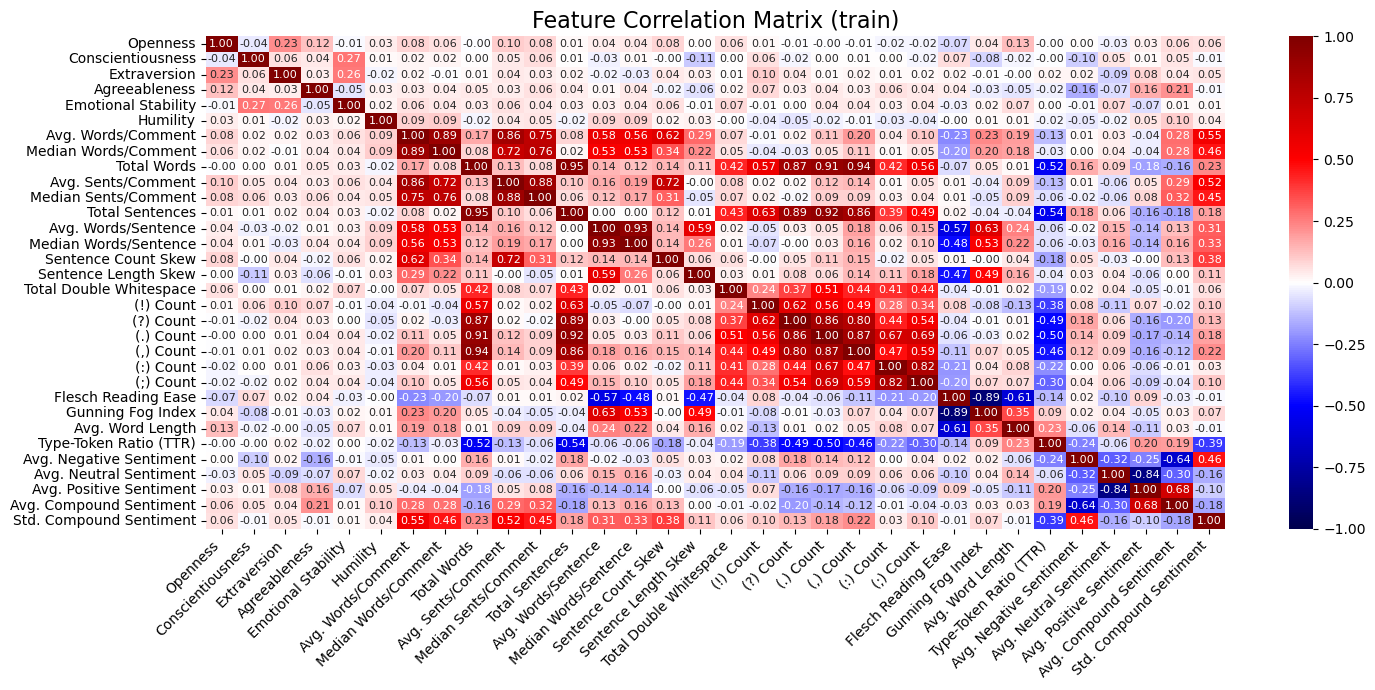

In [33]:
order = ['Unnamed: 0', 'id', 'comments','Openness','Conscientiousness','Extraversion','Agreeableness','Emotional stability','Humility',
       'comment_word_counts', 'mean_words_per_comment',
       'median_words_per_comment', 'total_words', 'mean_sents_per_comment',
       'median_sents_per_comment', 'total_sents', 'mean_words_per_sentence',
       'median_words_per_sentence', 'sents_per_comment_skew',
       'words_per_sentence_skew', 'total_double_whitespace', 'punc_em_total',
       'punc_qm_total', 'punc_period_total', 'punc_comma_total',
       'punc_colon_total', 'punc_semicolon_total', 'flesch_reading_ease_agg',
       'gunning_fog_agg', 'mean_word_len_overall', 'ttr_overall',
       'mean_sentiment_neg', 'mean_sentiment_neu', 'mean_sentiment_pos',
       'mean_sentiment_compound', 'std_sentiment_compound']
df_t = df_t.reindex(columns=order)
show_corr(df_t,save_name='train', cols_drop=['Unnamed: 0','id'], save=True)

Correlation plot saved to validation.png


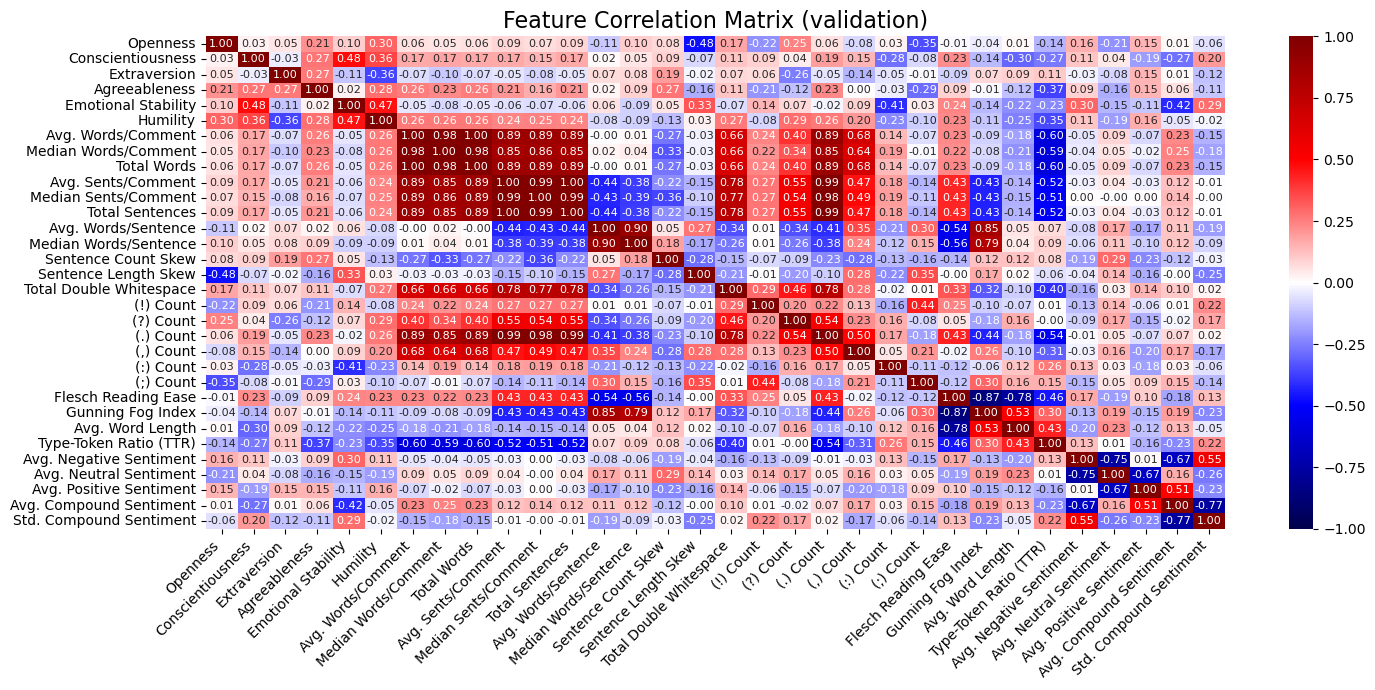

In [22]:
show_corr(df_v,cols_drop=['id','Unnamed: 0'],save_name='validation', save=True)

In [24]:
df_t.columns

Index(['Unnamed: 0', 'id', 'comments', 'Agreeableness', 'Conscientiousness',
       'Extraversion', 'Emotional stability', 'Openness', 'Humility',
       'comment_word_counts', 'mean_words_per_comment',
       'median_words_per_comment', 'total_words', 'mean_sents_per_comment',
       'median_sents_per_comment', 'total_sents', 'mean_words_per_sentence',
       'median_words_per_sentence', 'sents_per_comment_skew',
       'words_per_sentence_skew', 'total_double_whitespace', 'punc_em_total',
       'punc_qm_total', 'punc_period_total', 'punc_comma_total',
       'punc_colon_total', 'punc_semicolon_total', 'flesch_reading_ease_agg',
       'gunning_fog_agg', 'mean_word_len_overall', 'ttr_overall',
       'mean_sentiment_neg', 'mean_sentiment_neu', 'mean_sentiment_pos',
       'mean_sentiment_compound', 'std_sentiment_compound'],
      dtype='object')

In [23]:
def scatter(df,col_x,col_y):
    plt.figure(figsize=(8, 6)) # Optional: Adjust figure size
    plt.scatter(df[col_x], df[col_y], alpha=0.7, edgecolors='w', s=50) # s is marker size, alpha is transparency

    # Add labels and title for clarity
    plt.xlabel("X-axis Label (Name of Column X)")
    plt.ylabel("Y-axis Label (Name of Column Y)")
    plt.title("Scatter Plot of Column X vs Column Y")
    plt.grid(True) # Optional: Add a grid
    plt.show()

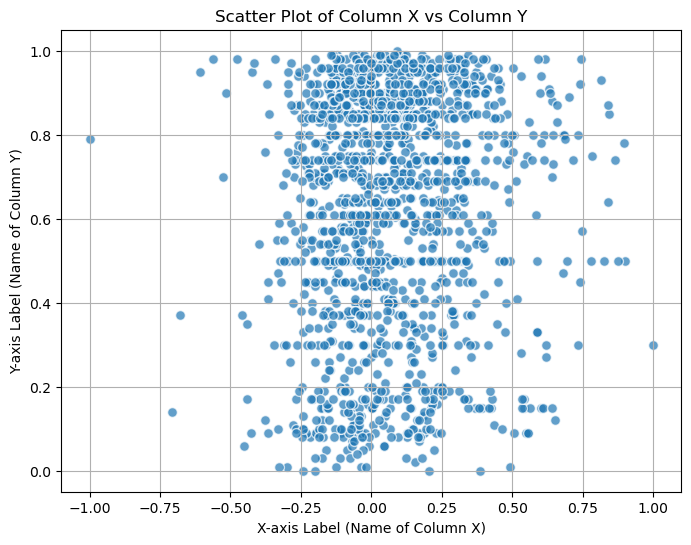

In [29]:
scatter(df_t,'mean_sentiment_compound','Openness')

In [31]:
import json

def get_first_line_from_jsonl(filepath):
    """Reads and returns the first line from a JSONL file."""
    try:
        with open(filepath, 'r') as f:
            first_line_str = f.readline()
            if first_line_str:
                return first_line_str.strip() # Remove trailing newline
            else:
                return None # File is empty
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def parse_json_string(json_string):
    """Parses a JSON string into a Python dictionary."""
    if json_string:
        try:
            return json.loads(json_string)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            return None
    return None

jsonl = r'update\train_data.jsonl'

fl = get_first_line_from_jsonl(jsonl)
print(fl)

{"labels": {"Openness": 0.99, "Conscientiousness": 0.96, "Extraversion": 0.6, "Agreeableness": 0.0, "Emotional stability": 0.99, "Humility": 0.02}, "features": {"mean_words_per_comment": -0.5131, "median_words_per_comment": -0.4771, "mean_sents_per_comment": -0.4694, "median_sents_per_comment": -0.4118, "mean_words_per_sentence": -0.6512, "median_words_per_sentence": -0.6901, "sents_per_comment_skew": -0.7887, "words_per_sentence_skew": -0.2841, "total_double_whitespace": -1.0, "punc_em_total": -1.0, "punc_qm_total": -0.9998, "punc_period_total": -0.9994, "punc_comma_total": -0.9993, "punc_colon_total": -0.9993, "punc_semicolon_total": -0.9997, "flesch_reading_ease_agg": 0.7425, "gunning_fog_agg": -0.8252, "mean_word_len_overall": -0.5902, "ttr_overall": 0.0708, "mean_sentiment_neg": -0.1691, "mean_sentiment_neu": -0.1436, "mean_sentiment_pos": -0.1368, "mean_sentiment_compound": 0.1799, "std_sentiment_compound": 0.5052, "q_scores": [[0.3297, 0.2314, 0.4482], [0.6411, 0.433, 0.4923], [

In [ ]:
def get_q_score(df): # Renamed for clarity
    if torch.cuda.is_available(): device = 'cuda'
    else: device = 'cpu'
    classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli', device = device)
    labels = [
        'an answer to: "Please describe a situation where you were presented with a problem outside of your comfort zone and where you were able to come up with a creative solution."', #q1
        'an answer to: "Tell us about a time when you have failed or made a mistake. What happened? What did you learn from this experience?"', #q2
        'an answer to: "Describe a situation in which you got a group of people to work together as a team. Did you encounter any issues? What was the end result?"' #q3
    ]
    for idx, row in df.iterrows(): # Iterate over the list
        print(f'Q-Scoring user {idx+1}/{len(df)}')
        user_comments = user_data.get('comments') # user_data is a dict
        if user_comments and isinstance(user_comments, list) and len(user_comments) > 0:
            try:
                results = classifier(user_comments, labels, multi_label=True) # Pass list of comments
                user_results_per_comment = []
                for result in results: # result is for one comment
                    result_scores = {label: round(score,4) for label, score in zip(result['labels'], result['scores'])}
                    q_scores_for_comment = [
                        result_scores[labels[0]], result_scores[labels[1]], result_scores[labels[2]]
                    ]
                    user_results_per_comment.append(q_scores_for_comment)
                user_data['features']['q_scores'] = user_results_per_comment
            except Exception as e: print(f'Error in Q-scoring for user {i}: {e}')
        else:
             user_data['features']['q_scores'] = [] # Ensure key exists even if no comments
             # print(f'No comments or invalid format for Q-scoring user {i}')
    return input_list_of_dicts # Modified in-place

In [ ]:
#execute
import torch
from transformers import pipeline
def get_q_score(df): # Renamed for clarity
    if torch.cuda.is_available(): device = 'cuda'
    else: device = 'cpu'
    classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli', device = device)
    labels = [
        'an answer to: "Please describe a situation where you were presented with a problem outside of your comfort zone and where you were able to come up with a creative solution."', #q1
        'an answer to: "Tell us about a time when you have failed or made a mistake. What happened? What did you learn from this experience?"', #q2
        'an answer to: "Describe a situation in which you got a group of people to work together as a team. Did you encounter any issues? What was the end result?"' #q3
    ]
    y_pred = []
    for index, row in df.iterrows():
        temp_result = []
        sequence = [row['Q1'], row['Q2'], row['Q3']]
        for i, q in enumerate(sequence):

            result_single = classifier(q, labels, multi_label=True)
            ordered_result = str({label: score for label, score in zip(result_single['labels'], result_single['scores'])})
            keys_iter = iter(ordered_result)
            key1 = next(keys_iter)
            value_k1 = ordered_result[key1]
            temp_result.append(value_k1)
        y_pred.extend(temp_result)
    return y_pred



In [ ]:
from sklearn.metrics import classification_report
import torch 

df_val = pd.read_csv(r'shared task\data\val_data_realvalued.csv')
y_true = []
y_pred = get_q_score(df_val)

if len(y_true) == len(y_pred):
    report = classification_report(y_true,y_pred)

Device set to use cuda


{'sequence': 'When I was the chairman of a student organisation, there was some friction between two board members in the organisation. Conflict among peers is something I really struggle with, especially in situations as this one. Since I was the chairman, I had to remain neutral on the one hand, while on the other hand also making this conflict does not remain unresolved. Because of this friction, I had decided to conduct a small informal meeting in which both members could talk things out and I had to moderate their conversation. As a result of this conversation, both members could see eye to eye again and the fiction did not expand into something worse. This was one of the first times in which I had to moderate a discussion between two friends and both were relieved that I took the time to focus on their well-being.', 'labels': ['an answer to: "Describe a situation in which you got a group of people to work together as a team. Did you encounter any issues? What was the end result?"

KeyboardInterrupt: 

In [ ]:
            df.loc[index, f'Q{i+1}_single'] = str({label: score for label, score in zip(result_single['labels'], result_single['scores'])})

    #check counts
    df['Q1_single'] = df['Q1_single'].apply(eval)
    df['Q2_single'] = df['Q2_single'].apply(eval)
    df['Q3_single'] = df['Q3_single'].apply(eval)

    # Extract the first key-value pair from each dictionary in the specified columns
    df['Q1_first'] = df['Q1_single'].apply(lambda x: list(x.keys())[0] if isinstance(x, dict) else None)
    df['Q2_first'] = df['Q2_single'].apply(lambda x: list(x.keys())[0] if isinstance(x, dict) else None)
    df['Q3_first'] = df['Q3_single'].apply(lambda x: list(x.keys())[0] if isinstance(x, dict) else None)

    print(df['Q1_first'].value_counts())
    print(df['Q2_first'].value_counts())
    print(df['Q3_first'].value_counts())